In [251]:
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2
from PIL import Image as img
import math

#### Henter bilder og disparities

In [252]:


BRYGGE_SEKVENS = "./bilder/brygge_sekvens"
BRO_SEKVENS = "./bilder/bro_sekvens"
LAGRA_BILDER = ".bilder/lagra_bilete"
BLANDA_SEKVENS = "./bilder/blanda_sekvens"
RESULT_FOLDER = BRYGGE_SEKVENS

K = np.loadtxt(f"{RESULT_FOLDER}/left/K_matrix.txt")
R = np.loadtxt(f"{RESULT_FOLDER}/left/R_matrix.txt")
T = np.loadtxt(f"{RESULT_FOLDER}/left/T_matrix.txt")

plt.ion()

# Under åpner vi ti = n'te bildet
left_images_filenames = list(filter(lambda fn: fn.split(".")[-1]=="png", os.listdir(f"{RESULT_FOLDER}/left")))
timestamps = list(map(lambda fn: fn.split(".")[0], left_images_filenames))
ti = 0
timestamp = timestamps[ti]
left = cv2.imread(f"{RESULT_FOLDER}/left/{timestamp}.png")
right = cv2.imread(f"{RESULT_FOLDER}/right/{timestamp}.png")
disp = np.array(cv2.imread(f"{RESULT_FOLDER}/disp_zed/{timestamp}.png", cv2.IMREAD_ANYDEPTH) / 256.0, dtype=np.float32)

print("Første:" ,timestamps[0], " Nærme: ", timestamps[len(timestamps)-1])

def fetch_image(main_as_well=False, RES_FOLDER=RESULT_FOLDER, time=timestamp):

    plt.ion()
    new_main_image = cv2.imread(f"{RES_FOLDER}/left/{time}.png")
    new_disparity_image = np.array(cv2.imread(f"{RES_FOLDER}/disp_zed/{time}.png", cv2.IMREAD_ANYDEPTH) / 256.0, dtype=np.float32)
    if(main_as_well):
        return new_disparity_image, new_main_image
    return new_disparity_image

# Timestamps
# Første: 1689072599961543541  Nærme:  1689072633388130541 Bru:  1689068851836122093 Båt: 1689068854381001093
Første= 1689072599961543541  
Nærme=  1689072633388130541
Bru =  1689068851836122093
Båt =  1689068854381001093

# Fra blanda
Kajakk1 = 1689068879500907093
KajakkOgBåt = 1689068879500907093
KajakkBåtTett = 1689068866505573093
BåtBak = 1689068856993399093
BåtFram = 1689068871596675093
BaderingMann = 1689072623607882541
Badering = 1689072630042776541
BaderingMannMidten = 1689072625349756541

 

# Fetch a new current working image and respective disparity
# Dette er disp_første og venstre_første
#current_working_disparity, current_working_image = fetch_image(True)

# Dette er disp_nærme_brygga og nærme_brygga
current_working_disparity, current_working_image = fetch_image(True, RES_FOLDER=BRYGGE_SEKVENS ,time=Første)
første_disparity, første_image = fetch_image(True, RES_FOLDER=BRYGGE_SEKVENS ,time=Første)
nærme_disparity, nærme_image = fetch_image(True, RES_FOLDER=BRYGGE_SEKVENS, time=Nærme)
bru_disparity, bru_image = fetch_image(True, RES_FOLDER=BRO_SEKVENS, time=Bru)
båt_disparity, båt_image = fetch_image(True, RES_FOLDER=BRO_SEKVENS, time=Båt)

kajakk_første_disparity, kajakk_første_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=Kajakk1)
kajakk_båt_disparity, kajakk_båt_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=KajakkOgBåt)
kajakk_tett_disparity, kajakk_tett_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=KajakkBåtTett)
båt_bak_disparity, båt_bak_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=BåtBak)
båt_fram_disparity, båt_fram_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=BåtFram)
badering_første_disparity, badering_første_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=Badering)
badering_mann_disparity, badering_mann_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=BaderingMann)
badering_midten_disparity, badering_midten_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=BaderingMannMidten)








Første: 1689072633388130541  Nærme:  1689072600363349541


In [253]:

count = 0
def interpolate_column(column):
    # Indices of valid and invalid elements
    # Adds the indices of values that are valid meaning real numbers to valid_indices and invalid indices meaning inf, -inf and NaN to 
    valid_mask = np.isfinite(column)
    valid_indices = np.where(valid_mask)[0]
    invalid_indices = np.where(~valid_mask)[0]

    # Check if we have enough data for interpolation
    if len(valid_indices) == 0:
        # No valid data in this column
        print("No valid data")
        return column
    elif len(invalid_indices) == 0:
        # No need for interpolation
        print("Not Necessary")
        return column

    #count +=1 
    # Interpolate invalid data points
    valid_data = column[valid_mask]
    column[~valid_mask] = np.interp(invalid_indices, valid_indices, valid_data)
    return column

def interpolate_each_column(dI):
    # Applying the interpolation to each column
    height, width = dI.shape
    for x in range(width):
        dI[:, x] = interpolate_column(dI[:, x])

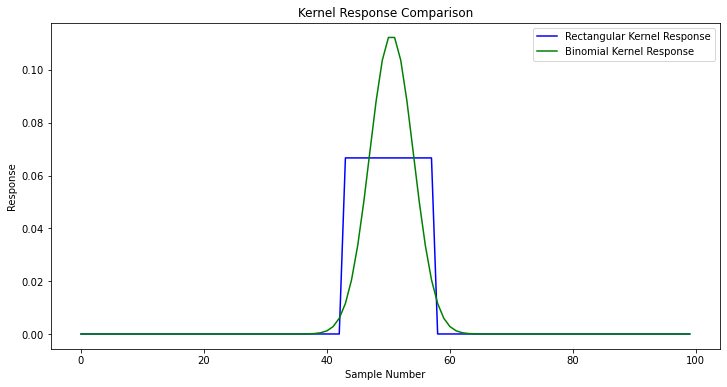

In [254]:
from scipy.special import binom

n = 50  # Length of the kernel
kernel_binomial = np.array([binom(n-1, k) for k in range(n)])
kernel_binomial = kernel_binomial / np.sum(kernel_binomial) 

n = 15  # Size of the kernel, as Vipul used in his thesis 5
kernel_k = np.ones(n) / n  # Kernel for averaging

# Create a signal with a single one in the middle
signal = np.zeros(100)
signal[50] = 1

# Apply the rectangular kernel
response_rectangular = np.convolve(signal, kernel_k, mode='same')

# Apply the binomial kernel
response_binomial = np.convolve(signal, kernel_binomial, mode='same')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(response_rectangular, label='Rectangular Kernel Response', color='blue')
plt.plot(response_binomial, label='Binomial Kernel Response', color='green')
plt.title('Kernel Response Comparison')
plt.xlabel('Sample Number')
plt.ylabel('Response')
plt.legend()
plt.show()

Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Necessary
Not Ne

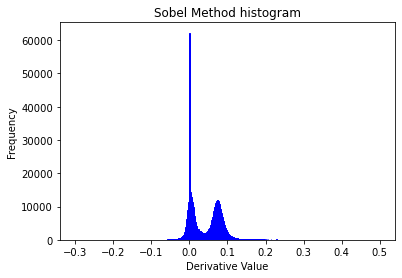

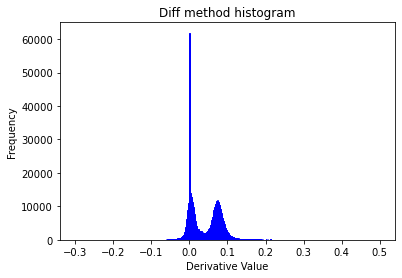

In [255]:
#Endring av input, teleporter hit

n = 15  # Size of the kernel, as Vipul used in his thesis 5
kernel_k = np.ones(n) / n  # Kernel for averaging

# Gaussian kernel:
n_gaussian = 15  # Size of the kernel
sigma_kernel = 2.0  # Standard deviation which controls the spread

def gaussian_kernel(n_gaussian=n_gaussian, sigma=sigma_kernel): 
    # Create a coordinate vector from -n//2 to n//2
    x = np.arange(-n_gaussian//2 + 1, n_gaussian//2 + 1)

    # Calculate the Gaussian function
    kernel_g = np.exp(-0.5 * (x**2) / sigma**2)

    # Normalize the kernel to ensure the sum of kernel elements equals 1
    kernel_g /= np.sum(kernel_g)

    return kernel_g

kernel_gaussian = gaussian_kernel()

# Old binomial kernel
""" n_binomial = 15

def binomial_kernel(size = n_binomial):
    kernel_b = np.array([1, 1])
    for i in range(size - 2):
        kernel_b = np.convolve(kernel_b, np.array([1, 1]))
    kernel_b = kernel_b.astype(float)
    kernel_b /= np.sum(kernel_b)  # Normalize the kernel
    return kernel_b

kernel_binomial = binomial_kernel() """
from scipy.special import binom

n = 30  # Length of the kernel
kernel_binomial = np.array([binom(n-1, k) for k in range(n)])
kernel_binomial = kernel_binomial / np.sum(kernel_binomial) 

# Velg input Kernel!
# Endre/change/velg
#-------------------------------------------
#input_kernel_lowpass = kernel_k
#kern_bool = True
input_kernel_lowpass = kernel_binomial
kern_bool = False
#-------------------------------------------


# Function to apply low-pass filter to a column
def low_pass_filter(column, K=kernel_k):
    # Apply convolution
    filtered_column = np.convolve(column, K, mode='same')
    return filtered_column


#-------------------------------------------
# Endre/change/velg
# Velg disparity bilde her!
#-------------------------------------------
#current_working_disparity, current_working_image 
#første_disparity, første_image 
#nærme_disparity, nærme_image 
#bru_disparity, bru_image 
#båt_disparity, båt_image
#
#dI = bru_disparity
#dI = båt_disparity
dI = første_disparity
#dI = nærme_disparity
#dI = kajakk_første_disparity
#dI = kajakk_båt_disparity
#dI = kajakk_tett_disparity
#dI = båt_bak_disparity
#dI = båt_fram_disparity
#dI = badering_første_disparity
#dI = badering_mann_disparity
#dI = badering_midten_disparity


#-------------------------------------------



interpolate_each_column(dI)

# This is manually doing the above cell
# Apply the low-pass filter to each column
height, width = dI.shape
df = np.zeros_like(dI)  # Low-pass filtered disparity image
for x in range(width):
    df[:, x] = low_pass_filter(dI[:, x], K=input_kernel_lowpass)

#df = cv2.filter2D(dI, -1, input_kernel_lowpass.reshape(-1, 1))  # Reshape for vertical application

# Versjon 1 bruker sobel Kernel til å derivere
# Define the 1D Sobel kernelS
kernel_m = np.array([1, 0, -1])

# Initialize an array to store the vertical derivative image
vertical_derivative = np.zeros_like(df)

# Apply the Sobel kernel to each column
""" for i in range(df.shape[1]):  # Iterate over columns
    vertical_derivative[:, i] = np.convolve(df[:, i], kernel_m, mode='same') """

for i in range(df.shape[1]):  # Iterate over columns
    vertical_derivative[:, i] = np.convolve(df[:, i], kernel_m, mode='same') / 2



# Versjon 2 bruker np.diff 
# Computing the derivative of each column
df_derivative = np.diff(df, axis=0)

# Padding to handle size difference after np.diff
df_derivative = np.pad(df_derivative, ((0, 1), (0, 0)), mode='edge')
#første_df_derivative = np.pad(df_derivative, ((0, 1), (0, 0)), mode='edge') 



# Input should be a disparity image where each column is differentiated
def flatten_and_plot_histogram(df_derivative, plot=True,title="Histogram of Derivative Values", input_bins=2000):
    # Flatten the array of derivatives to a 1D array
    flattened_derivatives = df_derivative.flatten()

    if(plot):
        # Plot the histogram
        plt.figure()
        plt.hist(flattened_derivatives, bins=input_bins, range=(-0.3,0.5), color='blue', edgecolor='blue')
        plt.title(title)
        plt.xlabel('Derivative Value')
        plt.ylabel('Frequency')
        # Show the plot
        plt.show()
    
    return flattened_derivatives
    

# Versjon 1 Sobel
flattened_derivatives_sobel = flatten_and_plot_histogram(vertical_derivative, title="Sobel Method histogram")

# Versjon 2 np.diff
flattened_derivatives_diff = flatten_and_plot_histogram(df_derivative, title="Diff method histogram")

#flattened_derivatives = flattened_derivatives_sobel

flattened_derivatives = flattened_derivatives_diff

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[[0.47652733]
 [0.47333205]
 [0.47104025]
 ...
 [0.07610703]
 [0.06294632]
 [0.04887009]]


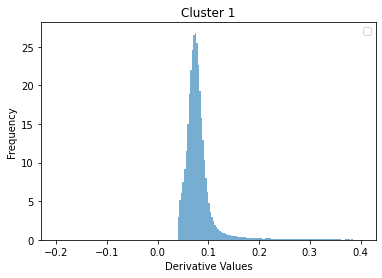

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


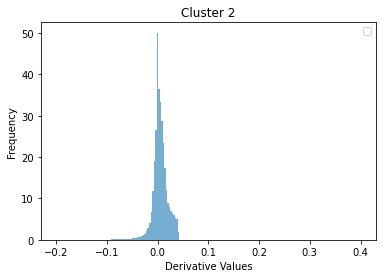

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


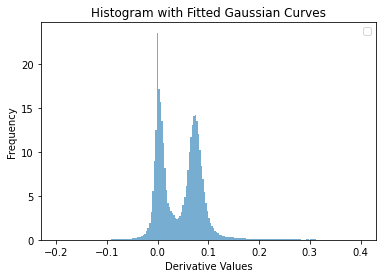

<class 'numpy.ndarray'>
mode:  [0.]


In [256]:
from sklearn.cluster import KMeans
from scipy import stats

def gaussian(x, mean, stddev):
    return (1 / (stddev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / stddev) ** 2)

# Gaussian fit function
def fit_gaussian(data):
    mean = np.mean(data)
    stddev = np.std(data)
    return mean, stddev

def clustering(flattened_derivatives, guess1=[0.0], guess2=[0.06], a_mini=-0.3, a_maxi=0.5, clusters=2):
    # Clipping the data to be between -0.3 and 0.5
    clipped_derivatives = np.clip(flattened_derivatives, a_min=a_mini, a_max=a_maxi)

    # Reshape data for KMeans
    clustering_model = clipped_derivatives.reshape(-1, 1)
    
    # Initial guesses for cluster centers (approximated from histogram peaks)
    initial_centers = np.array([guess1, guess2])  # replace peak1, peak2 with your estimates

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=clusters, init=initial_centers, n_init=1)
    kmeans.fit(clustering_model)

    # Get the labels and cluster centers
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    return clustering_model, clipped_derivatives, labels, centers

def clusteringV2(flattened_derivatives, a_mini=-0.3, a_maxi=0.5, clusters=2):
    # Clipping the data to be between -0.3 and 0.5
    clipped_derivatives = np.clip(flattened_derivatives, a_min=a_mini, a_max=a_maxi)

    # Reshape data for KMeans
    clustering_model = clipped_derivatives.reshape(-1, 1)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=clusters, init='k-means++', n_init=10)
    kmeans.fit(clustering_model)

    # Get the labels and cluster centers
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    return clustering_model, clipped_derivatives, labels, centers

# Sobel versjon
#clustering_model, labels, centers = clustering(flattened_derivatives_sobel, guess1=[0.0], guess2=[0.15])
# Diff
clustering_model, clipped_derivatives, labels, centers = clusteringV2(flattened_derivatives_diff)

# Relocation the mean to match the mode for a more accurate distribution

cluster1 = clustering_model[labels == 0]
cluster2 = clustering_model[labels == 1]

print(cluster1)

plt.figure()
plt.hist(cluster1, bins=200, range=(-0.2, 0.4), density=True, alpha=0.6)
plt.xlabel('Derivative Values')
plt.ylabel('Frequency')
plt.title('Cluster 1')
plt.legend()
plt.show()

# Plot histogram 
plt.figure()
plt.hist(cluster2, bins=200, range=(-0.2, 0.4), density=True, alpha=0.6)
plt.xlabel('Derivative Values')
plt.ylabel('Frequency')
plt.title('Cluster 2')
plt.legend()
plt.show()

plt.figure()
plt.hist(clustering_model, bins=200, range=(-0.2, 0.4), density=True, alpha=0.6)
plt.xlabel('Derivative Values')
plt.ylabel('Frequency')
plt.title('Histogram with Fitted Gaussian Curves')
plt.legend()
plt.show()

mode_result = stats.mode(cluster2)
print(type(mode_result.mode))

print("mode: ", stats.mode(cluster2).mode[0])


#print("mean: ",np.mean(cluster1))
#print("mode: ", stats.mode(cluster1).mode)


Mean 1:  0.0816652
Stddev 1:  0.03870869
Mean 2:  0.0003834353
Stddev 2:  0.039541513
Mode 1:  [0.5]
Mode 2:  [0.]


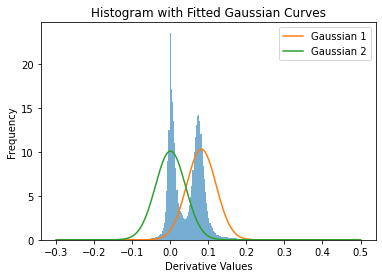

In [257]:

# Fit Gaussian to each cluster
mean1, stddev1 = fit_gaussian(cluster1)
mean2, stddev2 = fit_gaussian(cluster2)
#stddev1, stddev2 = 0.02, 0.02
print("Mean 1: ",mean1)
print("Stddev 1: ",stddev1)
print("Mean 2: ",mean2)
print("Stddev 2: ",stddev2)
print("Mode 1: ", stats.mode(cluster1).mode[0])
print("Mode 2: ", stats.mode(cluster2).mode[0])

if(kern_bool):
    mean1 = stats.mode(cluster1).mode[0]
    mean2 = stats.mode(cluster2).mode[0]


# Determine which mean is closer to 0 and assign labels
if abs(mean1) < abs(mean2):
    red_mean, green_mean = mean1, mean2
    red_stddev, green_stddev = stddev1, stddev2
    red_label, green_label = 'Cluster 1 (Red)', 'Cluster 2 (Green)'
else:
    red_mean, green_mean = mean2, mean1
    red_stddev, green_stddev = stddev2, stddev1
    red_label, green_label = 'Cluster 2 (Red)', 'Cluster 1 (Green)'

# Below are the upper and lower bounds
# Assuming you have mean1, stddev1, mean2, stddev2 from the Gaussian fits
k = 1 # Adjust this constant as needed

""" shift_amount = 0.02  # Adjust this value to shift the curve to the left
# Adjust mean2 for Gaussian Curve 2
adjusted_mean2 = mean2 - shift_amount
mean2 = mean2 - shift_amount 
#gaussian_curve2Adjust = gaussian(x_values, adjusted_mean2, stddev2)
"""

# Calculate range limits for each Gaussian curve
dL1 = mean1 - k * stddev1
dU1 = mean1 + k * stddev1
dL2 = mean2 - k * stddev2
dU2 = mean2 + k * stddev2

red_dL = red_mean - k * red_stddev
red_dU = red_mean + k * red_stddev
green_dL = green_mean - k * green_stddev
green_dU = green_mean + k * green_stddev


# Create a range of x values
x_values = np.linspace(-0.3, 0.5, 400)



# Gaussian curves
gaussian_curve1 = gaussian(x_values, mean1, stddev1)
gaussian_curve2 = gaussian(x_values, mean2, stddev2)


# Plot histogram and Gaussian curves
plt.figure()
plt.hist(clipped_derivatives, bins=200, range=(-0.2, 0.4), density=True, alpha=0.6)
plt.plot(x_values, gaussian_curve1, label='Gaussian 1')
plt.plot(x_values, gaussian_curve2, label='Gaussian 2')
plt.xlabel('Derivative Values')
plt.ylabel('Frequency')
plt.title('Histogram with Fitted Gaussian Curves')
plt.legend()
plt.show()

In [258]:
""" # And dL1, dU1, dL2, dU2 are the range limits for the two Gaussians
classification_map = np.empty(df_derivative.shape, dtype=object)

include_undecided_label = True

if(include_undecided_label):
    print("includes undecided")
    for i in range(df_derivative.shape[0]):  # Rows
        for j in range(df_derivative.shape[1]):  # Columns
            derivative_value = df_derivative[i, j]

            # Check if the derivative value falls into the range of either Gaussian
            if (dL1 <= derivative_value <= dU1) and (dL2 <= derivative_value <= dU2):
                classification = 'undecided'
            elif dL1 <= derivative_value <= dU1:
                classification = 'upright' 
            elif dL2 <= derivative_value <= dU2:
                 classification = 'horizontal'  
            else:
                classification = 'unknown'

            classification_map[i, j] = classification
else:
    print("Does not include undecided")
    for i in range(df_derivative.shape[0]):  # Rows
        for j in range(df_derivative.shape[1]):  # Columns
            derivative_value = df_derivative[i, j]

            # Check if the derivative value falls into the range of either Gaussian
            if dL1 <= derivative_value <= dU1:
                classification = 'upright'
            elif dL2 <= derivative_value <= dU2:
                classification = 'horizontal'
            else:
                classification = 'unknown'

            classification_map[i, j] = classification

print(df_derivative)
print(classification_map) """

' # And dL1, dU1, dL2, dU2 are the range limits for the two Gaussians\nclassification_map = np.empty(df_derivative.shape, dtype=object)\n\ninclude_undecided_label = True\n\nif(include_undecided_label):\n    print("includes undecided")\n    for i in range(df_derivative.shape[0]):  # Rows\n        for j in range(df_derivative.shape[1]):  # Columns\n            derivative_value = df_derivative[i, j]\n\n            # Check if the derivative value falls into the range of either Gaussian\n            if (dL1 <= derivative_value <= dU1) and (dL2 <= derivative_value <= dU2):\n                classification = \'undecided\'\n            elif dL1 <= derivative_value <= dU1:\n                classification = \'upright\' \n            elif dL2 <= derivative_value <= dU2:\n                 classification = \'horizontal\'  \n            else:\n                classification = \'unknown\'\n\n            classification_map[i, j] = classification\nelse:\n    print("Does not include undecided")\n    for 

In [259]:
# And dL1, dU1, dL2, dU2 are the range limits for the two Gaussians
classification_map = np.empty(df_derivative.shape, dtype=object)

include_undecided_label = True

if include_undecided_label:
    print("includes undecided")
    for i in range(df_derivative.shape[0]):  # Rows
        for j in range(df_derivative.shape[1]):  # Columns
            derivative_value = df_derivative[i, j]

            # Check if the derivative value falls into the range of either Gaussian
            if (red_dL <= derivative_value <= red_dU) and (green_dL <= derivative_value <= green_dU):
                classification = 'undecided'
            elif red_dL <= derivative_value <= red_dU:
                classification = 'upright'  # Red cluster
            elif green_dL <= derivative_value <= green_dU:
                classification = 'horizontal'  # Green cluster
            else:
                classification = 'unknown'

            classification_map[i, j] = classification
else:
    print("Does not include undecided")
    for i in range(df_derivative.shape[0]):  # Rows
        for j in range(df_derivative.shape[1]):  # Columns
            derivative_value = df_derivative[i, j]

            # Check if the derivative value falls into the range of either Gaussian
            if red_dL <= derivative_value <= red_dU:
                classification = 'upright'  # Red cluster
            elif green_dL <= derivative_value <= green_dU:
                classification = 'horizontal'  # Green cluster
            else:
                classification = 'unknown'

            classification_map[i, j] = classification

print(df_derivative)
print(classification_map)


includes undecided
[[ 0.47652733  0.47333205  0.47104025 ...  0.39295352  0.4030671
   0.4152527 ]
 [ 0.4171095   0.4144504   0.41228342 ...  0.33079076  0.3386103
   0.34897113]
 [ 0.31893873  0.3171184   0.31532001 ...  0.23579383  0.2403543
   0.24781561]
 ...
 [-4.8831444  -4.8872375  -4.885849   ... -4.8792534  -4.8827057
  -4.886776  ]
 [-6.530487   -6.5260277  -6.514984   ... -6.4012337  -6.4044647
  -6.407852  ]
 [-6.530487   -6.5260277  -6.514984   ... -6.4012337  -6.4044647
  -6.407852  ]]
[['unknown' 'unknown' 'unknown' ... 'unknown' 'unknown' 'unknown']
 ['unknown' 'unknown' 'unknown' ... 'unknown' 'unknown' 'unknown']
 ['unknown' 'unknown' 'unknown' ... 'unknown' 'unknown' 'unknown']
 ...
 ['unknown' 'unknown' 'unknown' ... 'unknown' 'unknown' 'unknown']
 ['unknown' 'unknown' 'unknown' ... 'unknown' 'unknown' 'unknown']
 ['unknown' 'unknown' 'unknown' ... 'unknown' 'unknown' 'unknown']]


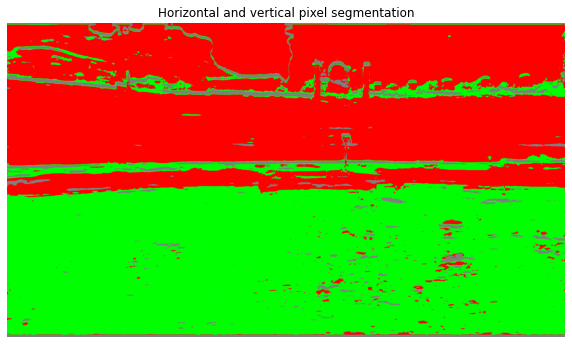

In [260]:
# Define colors for each classification
colors = {
    'undecided': [0, 0, 1], # Blue
    'upright': [1, 0, 0],  # Red
    'horizontal': [0, 1, 0],  # Green
    'unknown': [0.5, 0.5, 0.5]  # Gray
}

def assign_colours_and_plot(classification_map, colors=colors, plot=True, title="Pixel-wise Disparity Map Classification"):
    # Create an empty array for the color-coded image
    color_coded_image = np.zeros((*classification_map.shape, 3))

    # Assign colors
    for classification, color in colors.items():
        mask = classification_map == classification
        color_coded_image[mask] = color

    if(plot):
        plt.figure(figsize=(10, 6))
        plt.imshow(color_coded_image)
        plt.title(title)
        plt.axis('off')  # Hide the axes
        plt.show()

# Nærme
#display_disp_image(nærme_image)
# Båt
#display_disp_image(båt_test_bilde)
assign_colours_and_plot(classification_map, title="Horizontal and vertical pixel segmentation")

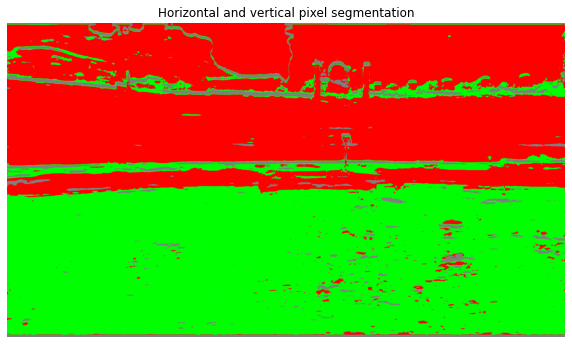

In [261]:
#SAMME KODE SOM OVER
# Define colors for each classification
colors = {
    'undecided': [0, 0, 1], # Blue
    'upright': [1, 0, 0],  # Red
    'horizontal': [0, 1, 0],  # Green
    'unknown': [0.5, 0.5, 0.5]  # Gray
}

def assign_colours_and_plot(classification_map, colors=colors, plot=True, title="Pixel-wise Disparity Map Classification"):
    # Create an empty array for the color-coded image
    color_coded_image = np.zeros((*classification_map.shape, 3))

    # Assign colors
    for classification, color in colors.items():
        mask = classification_map == classification
        color_coded_image[mask] = color

    if(plot):
        plt.figure(figsize=(10, 6))
        plt.imshow(color_coded_image)
        plt.title(title)
        plt.axis('off')  # Hide the axes
        plt.show()

# Nærme
#display_disp_image(nærme_image)
# Båt
#display_disp_image(båt_test_bilde)
assign_colours_and_plot(classification_map, title="Horizontal and vertical pixel segmentation")

### Vertical surface splitting

In [299]:
surface_splitting_disparity_image = dI

vertCount = 0
horCount = 0
noneCount = 0

# Verticals
vertical_Derivative_List = []
vertical_Disp_List = []
vertical_Obj_List = []


#Horizonals
horizontal_Derivative_List = []
horizontal_Disp_List = []
horizontal_Obj_List = []

divided_horizontal_obj_list = []


for i in range(classification_map.shape[0]):  # Rows

    single_col_obj_list = []
    for j in range(classification_map.shape[1]):  # Columns

        current_local_value = classification_map[i, j]

        if(current_local_value == 'upright'):
            vertCount += 1
            vertical_Derivative_List.append(df_derivative[i,j])
            appendObjectVert = [surface_splitting_disparity_image[i, j], i, j, 'vertical']
            vertical_Disp_List.append(surface_splitting_disparity_image[i,j])
            vertical_Obj_List.append(appendObjectVert)
        
        
        
        elif(current_local_value == 'horizontal'):
            horCount += 1
            der_val = df_derivative[i, j]
            horizontal_Derivative_List.append(der_val)
            # Object = [Disparity value, vertical derivative value, i coordinate, j coordinate, label]
            appendObjectHor = [surface_splitting_disparity_image[i, j], der_val, i, j, 'horizontal']
            horizontal_Disp_List.append(surface_splitting_disparity_image[i,j])
            horizontal_Obj_List.append(appendObjectHor)
            single_col_obj_list.append(appendObjectHor)

        else:
            noneCount+=1
    divided_horizontal_obj_list.append(single_col_obj_list)

print("verticals: ", vertCount)
print("Horizontals: ", horCount)
print("Unknown: ", noneCount)
print("[Disparity Value, Derivative Value, V index, U index, Label]")
print(horizontal_Obj_List[202])

verticals:  947110
Horizontals:  1020833
Unknown:  105657
[Disparity Value, Derivative Value, V index, U index, Label]
[1.7304688, 0.11368966, 3, 523, 'horizontal']


In [319]:
#print(divided_horizontal_obj_list)
print((divided_horizontal_obj_list[800]))

[[30.15625, 0.06550598, 800, 0, 'horizontal'], [30.136719, 0.06602478, 800, 1, 'horizontal'], [30.101562, 0.06746483, 800, 2, 'horizontal'], [30.058594, 0.069381714, 800, 3, 'horizontal'], [30.027344, 0.06822014, 800, 4, 'horizontal'], [29.988281, 0.068151474, 800, 5, 'horizontal'], [29.964844, 0.067064285, 800, 6, 'horizontal'], [29.953125, 0.06842041, 800, 7, 'horizontal'], [29.949219, 0.06780434, 800, 8, 'horizontal'], [29.929688, 0.06833649, 800, 9, 'horizontal'], [29.917969, 0.06932449, 800, 10, 'horizontal'], [29.898438, 0.06970787, 800, 11, 'horizontal'], [29.882812, 0.070215225, 800, 12, 'horizontal'], [29.875, 0.07227898, 800, 13, 'horizontal'], [29.859375, 0.07178688, 800, 14, 'horizontal'], [29.875, 0.07343483, 800, 15, 'horizontal'], [29.890625, 0.07591629, 800, 16, 'horizontal'], [29.902344, 0.07752228, 800, 17, 'horizontal'], [29.933594, 0.07845497, 800, 18, 'horizontal'], [29.945312, 0.079769135, 800, 19, 'horizontal'], [29.960938, 0.080179214, 800, 20, 'horizontal'], [2

947110


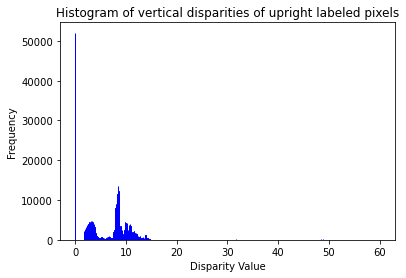

In [263]:
print(len(vertical_Derivative_List))

input_bins=2000
plot= True
title = 'Histogram of vertical disparities of upright labeled pixels'
histRange = (-0.3,0.5)

#to_be_plotted = verticalDerivativeList
#to_be_plotted = df_derivative.flatten()
to_be_plotted =vertical_Disp_List
histRange = (0,60)
if(plot):
    # Plot the histogram
    plt.figure()
    plt.hist(to_be_plotted, bins=input_bins, range=histRange, color='blue', edgecolor='blue')
    plt.title(title)
    plt.xlabel('Disparity Value')
    plt.ylabel('Frequency')
    # Show the plot
    plt.show()


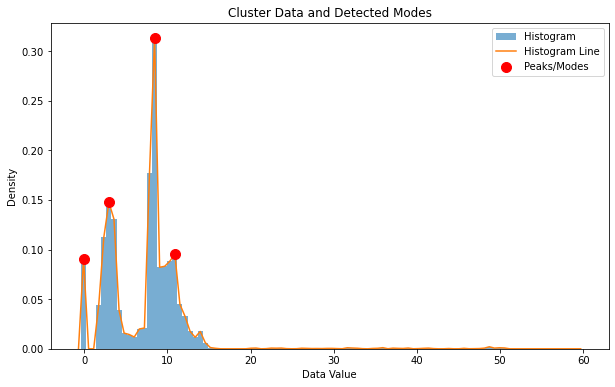

Detected modes at: [-0.08499999  2.9650002   8.455      10.895     ]


In [264]:
from scipy.signal import find_peaks
auto_range=(-1,60)
def plot_histogram_with_peaks(data, bins, min_prominence=0.01, min_distance=1, auto_range=auto_range):

    # Ensure data is cleaned
    data = np.array(data)
    data = data[np.isfinite(data)]


    hist, bin_edges = np.histogram(data,range=auto_range, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Get bin centers for plotting

    # Find peaks with adjusted parameters
    peaks, properties = find_peaks(hist, prominence=min_prominence, distance=min_distance)

    # Plotting the histogram and peaks
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins,  range=auto_range, alpha=0.6, label='Histogram', density=True)
    plt.plot(bin_centers, hist, label='Histogram Line')
    plt.scatter(bin_centers[peaks], hist[peaks],color='red', s=100, zorder=5, label='Peaks/Modes')
    plt.title('Cluster Data and Detected Modes')
    plt.xlabel('Data Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    # Print peak bin centers
    peak_values = bin_centers[peaks]
    print("Detected modes at:", peak_values)
    return peak_values

# Call the function with parameters adjusted based on your description
detected_modes = plot_histogram_with_peaks(vertical_Disp_List, bins=100, min_prominence=0.01, min_distance=1)


In [265]:
testing_list = []
for i in detected_modes:
    print(i)
    testing_list.append(i)
print(testing_list)

-0.08499999
2.9650002
8.455
10.895
[-0.08499999, 2.9650002, 8.455, 10.895]


In [266]:
print(detected_modes[1])
initial_centers = np.array(detected_modes)

print(initial_centers)

testing_list = []
for i in detected_modes:
    print(i)
    testing_list.append([i])
print(testing_list)

first_centers = np.array(testing_list)
print(initial_centers)
""" 
guess1=[-0.08499999]
guess2=[1.745]

initial_centers = np.array([guess1, guess2])

print(initial_centers) """


2.9650002
[-0.08499999  2.9650002   8.455      10.895     ]
-0.08499999
2.9650002
8.455
10.895
[[-0.08499999], [2.9650002], [8.455], [10.895]]
[-0.08499999  2.9650002   8.455      10.895     ]


' \nguess1=[-0.08499999]\nguess2=[1.745]\n\ninitial_centers = np.array([guess1, guess2])\n\nprint(initial_centers) '

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


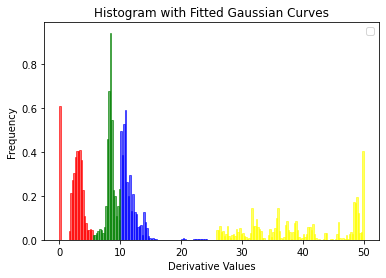

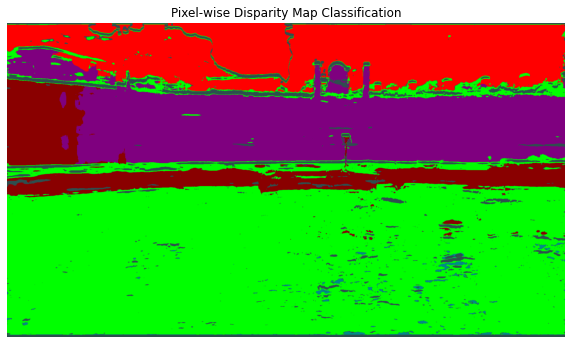

In [267]:


def clusteringVerticalSurfaces(flattened_derivatives, guess1=[-0.08499999], guess2=[1.745], guess3=[7], guess4=[10], a_mini=-0.3, a_maxi=50, clusters=4):
    # Clipping the data to be between -0.3 and 0.5
    clipped_derivatives = np.clip(flattened_derivatives, a_min=a_mini, a_max=a_maxi)

    # Reshape data for KMeans
    clustering_model = clipped_derivatives.reshape(-1, 1)
    
    #initial_centers = np.array([guess1, guess2])
    initial_centers = first_centers
    # Perform K-means clustering
    #kmeans = KMeans(n_clusters=clusters, init=initial_centers, n_init=1)
    kmeans = KMeans(n_clusters=clusters, init='k-means++', n_init=10)
    kmeans.fit(clustering_model)

    # Get the labels and cluster centers
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    return clustering_model, clipped_derivatives, labels, centers

num_clusters = len(detected_modes)


clustering_model, clipped_derivatives, labels, centers = clusteringVerticalSurfaces(vertical_Disp_List, clusters=num_clusters)

# Separate the data into two clusters

if(num_clusters>= 1):
    cluster1 = clustering_model[labels == 0]
if(num_clusters>= 2):
    cluster2 = clustering_model[labels == 1]
if(num_clusters >= 3):
    cluster3 = clustering_model[labels == 2]
if(num_clusters >= 4):
    cluster4 = clustering_model[labels == 3]
if(num_clusters >= 5):
    cluster5 = clustering_model[labels == 4]



# Plot histogram and Gaussian curves
plt.figure()
if(num_clusters>= 1):
    plt.hist(cluster1, bins=200, range=(0, 50), density=True, alpha=0.6, color='blue', edgecolor='blue')
if(num_clusters>= 2):
    plt.hist(cluster2, bins=200, range=(0, 50), density=True, alpha=0.6, color='red', edgecolor='red')
if(num_clusters>= 3):
    plt.hist(cluster3, bins=200, range=(0, 50), density=True, alpha=0.6, color='green', edgecolor='green')
if(num_clusters>= 4):
    plt.hist(cluster4, bins=200, range=(0, 50), density=True, alpha=0.6, color='yellow', edgecolor='yellow')
if(num_clusters>= 5):
    plt.hist(cluster5, bins=200, range=(0, 50), density=True, alpha=0.6, color='purple', edgecolor='purple')
#plt.plot(x_values, gaussian_curve1, label='Gaussian 1')
#plt.plot(x_values, gaussian_curve2, label='Gaussian 2')
plt.xlabel('Derivative Values')
plt.ylabel('Frequency')
plt.title('Histogram with Fitted Gaussian Curves')
plt.legend()
plt.show()

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Create classmap
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------


for i, obj in enumerate(vertical_Obj_List):
    if(labels[i] == 0):
        obj[3] = "vertical1"
    elif(labels[i] == 1):
        obj[3] = "vertical2"
    elif(labels[i] == 2):
        obj[3] = "vertical3"
    elif(labels[i] == 3):
        obj[3] = "vertical4"
    else:
        obj[3] = "Vertical5"

new_class_map = np.copy(classification_map)

for i, obj in enumerate(vertical_Obj_List):
    i = obj[1]
    j= obj[2]
    new_class_map[i,j] = obj[3]

Dark_Red = [139/256, 0,0]
Pure_Red = [1,0,0]
Navy_Blue= [0, 0,128/256]
Dark_Slate_Gray=[47/256, 79/256, 79/256]
Chocolate= [210/256, 105/256, 30/256]
Saddle_Brown= [139/256, 69/256, 19/256]
Firebrick =[178/256, 34/256, 34/256]
Dark_Goldenrod=[184/256, 134/256, 11/256]
Midnight_Blue=[25/256, 25/256, 112/256]
Indigo =[75/256, 0, 130/256]
Sienna=[160/256, 82/256, 45/256]
Purple = [128/256,0 , 128/256]
Black = [0,0,0]
White = [1,1,1]
#Greens
Olive_Green= [85/256, 107/256, 47/256]
Forest_Green= [34/256, 139/256, 34/256]
Pure_Green= [0, 1, 0]
Teal= [0, 128/256, 128/256]
Dark_Cyan= [0, 139/256, 139/256]
Dark_Green= [0, 100/256, 0]


# Define colors for each classification
colorsV3 = {
    'vertical1': Dark_Red,  # Navy blue  
    'vertical2': Pure_Red,  # Pure red
    'vertical3': Purple,  # Purple
    'vertical4': Dark_Cyan,  # Cyan
    'vertical5': Navy_Blue,
    'horizontal': Pure_Green,  # Green
    'unknown': Dark_Slate_Gray,  # Gray
    'undecided': Saddle_Brown

}


# Create an empty array for the color-coded image
color_coded_image = np.zeros((*new_class_map.shape, 3))
#print(color_coded_image)


color_coded_image = np.zeros((*new_class_map.shape, 3))

# Assign colors based on the classification in new_class_map
for label, color in colorsV3.items():
    # Find indices where the current label is present in new_class_map
    indices = np.where(new_class_map == label)
    # Assign the corresponding color to these indices in the color-coded image
    color_coded_image[indices] = color

#print(color_coded_image)
plt.figure(figsize=(10, 6))
plt.imshow(color_coded_image)
plt.title('Pixel-wise Disparity Map Classification')
plt.axis('off')  # Hide the axes
plt.show() 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


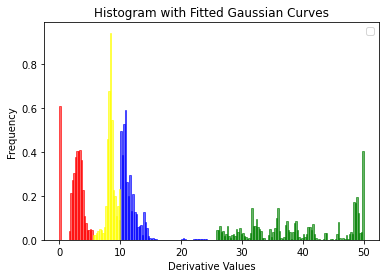

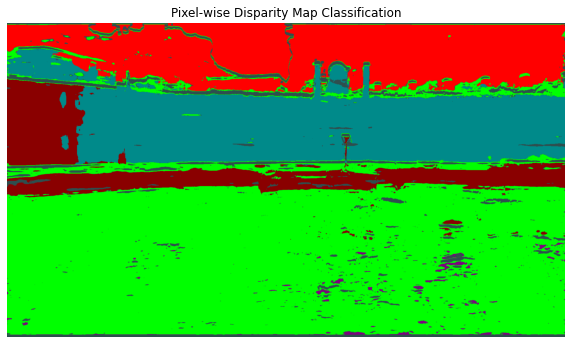

In [268]:
# Samme som over

def clusteringVerticalSurfaces(flattened_derivatives, a_mini=-0.3, a_maxi=50, clusters=4):
    # Clipping the data to be between -0.3 and 0.5
    clipped_derivatives = np.clip(flattened_derivatives, a_min=a_mini, a_max=a_maxi)

    # Reshape data for KMeans
    clustering_model = clipped_derivatives.reshape(-1, 1)
    
    # Perform K-means clustering
    #kmeans = KMeans(n_clusters=clusters, init=initial_centers,n_init=2)
    kmeans = KMeans(n_clusters=clusters, init='k-means++', n_init=10)
    kmeans.fit(clustering_model)

    # Get the labels and cluster centers
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    return clustering_model, clipped_derivatives, labels, centers

num_clusters = len(detected_modes)


clustering_model, clipped_derivatives, labels, centers = clusteringVerticalSurfaces(vertical_Disp_List, clusters=num_clusters)

# Separate the data into two clusters

if(num_clusters>= 1):
    cluster1 = clustering_model[labels == 0]
if(num_clusters>= 2):
    cluster2 = clustering_model[labels == 1]
if(num_clusters >= 3):
    cluster3 = clustering_model[labels == 2]
if(num_clusters >= 4):
    cluster4 = clustering_model[labels == 3]
if(num_clusters >= 5):
    cluster5 = clustering_model[labels == 4]



# Plot histogram and Gaussian curves
plt.figure()
if(num_clusters>= 1):
    plt.hist(cluster1, bins=200, range=(0, 50), density=True, alpha=0.6, color='blue', edgecolor='blue')
if(num_clusters>= 2):
    plt.hist(cluster2, bins=200, range=(0, 50), density=True, alpha=0.6, color='red', edgecolor='red')
if(num_clusters>= 3):
    plt.hist(cluster3, bins=200, range=(0, 50), density=True, alpha=0.6, color='green', edgecolor='green')
if(num_clusters>= 4):
    plt.hist(cluster4, bins=200, range=(0, 50), density=True, alpha=0.6, color='yellow', edgecolor='yellow')
if(num_clusters>= 5):
    plt.hist(cluster5, bins=200, range=(0, 50), density=True, alpha=0.6, color='purple', edgecolor='purple')
#plt.plot(x_values, gaussian_curve1, label='Gaussian 1')
#plt.plot(x_values, gaussian_curve2, label='Gaussian 2')
plt.xlabel('Derivative Values')
plt.ylabel('Frequency')
plt.title('Histogram with Fitted Gaussian Curves')
plt.legend()
plt.show()

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Create classmap
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------


for i, obj in enumerate(vertical_Obj_List):
    if(labels[i] == 0):
        obj[3] = "vertical1"
    elif(labels[i] == 1):
        obj[3] = "vertical2"
    elif(labels[i] == 2):
        obj[3] = "vertical3"
    elif(labels[i] == 3):
        obj[3] = "vertical4"
    else:
        obj[3] = "Vertical5"

new_class_map = np.copy(classification_map)

for i, obj in enumerate(vertical_Obj_List):
    i = obj[1]
    j= obj[2]
    new_class_map[i,j] = obj[3]

Dark_Red = [139/256, 0,0]
Pure_Red = [1,0,0]
Navy_Blue= [0, 0,128/256]
Dark_Slate_Gray=[47/256, 79/256, 79/256]
Chocolate= [210/256, 105/256, 30/256]
Saddle_Brown= [139/256, 69/256, 19/256]
Firebrick =[178/256, 34/256, 34/256]
Dark_Goldenrod=[184/256, 134/256, 11/256]
Midnight_Blue=[25/256, 25/256, 112/256]
Indigo =[75/256, 0, 130/256]
Sienna=[160/256, 82/256, 45/256]
Purple = [128/256,0 , 128/256]
Black = [0,0,0]
White = [1,1,1]
#Greens
Olive_Green= [85/256, 107/256, 47/256]
Forest_Green= [34/256, 139/256, 34/256]
Pure_Green= [0, 1, 0]
Teal= [0, 128/256, 128/256]
Dark_Cyan= [0, 139/256, 139/256]
Dark_Green= [0, 100/256, 0]


# Define colors for each classification
colorsV3 = {
    'vertical1': Dark_Red,  # Navy blue  
    'vertical2': Pure_Red,  # Pure red
    'vertical3': Purple,  # Purple
    'vertical4': Dark_Cyan,  # Cyan
    'vertical5': Navy_Blue,
    'horizontal': Pure_Green,  # Green
    'unknown': Dark_Slate_Gray,  # Gray
    'undecided': Saddle_Brown

}


# Create an empty array for the color-coded image
color_coded_image = np.zeros((*new_class_map.shape, 3))
#print(color_coded_image)


color_coded_image = np.zeros((*new_class_map.shape, 3))

# Assign colors based on the classification in new_class_map
for label, color in colorsV3.items():
    # Find indices where the current label is present in new_class_map
    indices = np.where(new_class_map == label)
    # Assign the corresponding color to these indices in the color-coded image
    color_coded_image[indices] = color

#print(color_coded_image)
plt.figure(figsize=(10, 6))
plt.imshow(color_coded_image)
plt.title('Pixel-wise Disparity Map Classification')
plt.axis('off')  # Hide the axes
plt.show() 

In [269]:
surface_splitting_disparity_image.shape

import matplotlib.colors as mcolors

def generate_dark_colors(n):
    # Define the saturation and value for dark colors
    saturation = 1.0  # full saturation for vivid colors
    value = 0.6  # dark enough to ensure good contrast on a white background
    
    # Generate colors
    colors = []
    for i in range(n):
        hue = i / n  # Evenly space hues around the color wheel
        rgb = mcolors.hsv_to_rgb((hue, saturation, value))
        colors.append(rgb)
    
    return colors

# Example usage: generate 10 dark, distinct colors
num_colors = 10
dark_colors = generate_dark_colors(num_colors)
print("Dark colors:")
for i, color in enumerate(dark_colors):
    print(f"Color {i + 1}: {color}")

Dark colors:
Color 1: [0.6 0.  0. ]
Color 2: [0.6  0.36 0.  ]
Color 3: [0.48 0.6  0.  ]
Color 4: [0.12 0.6  0.  ]
Color 5: [0.   0.6  0.24]
Color 6: [0.  0.6 0.6]
Color 7: [0.   0.24 0.6 ]
Color 8: [0.12 0.   0.6 ]
Color 9: [0.48 0.   0.6 ]
Color 10: [0.6  0.   0.36]


[ 1.796875   1.8007812  1.8007812 ... 50.25      50.296875  50.335938 ]
[ 0.2603277   0.22793269  0.17442822 ... -4.8291016  -6.3329086
 -6.3329086 ]
['unknown' 'unknown' 'unknown' ... 'unknown' 'unknown' 'unknown']
564
IndexListHorCol:  [3, 4, 180, 181, 182, 183, 184, 185, 186, 187, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 508, 509, 510, 511, 568, 569, 570, 571, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 

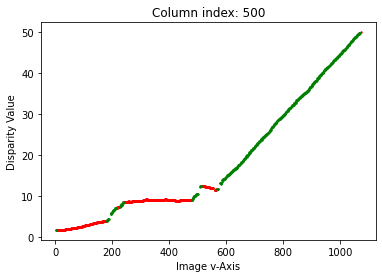

In [270]:
# Endre/change/velg
# Velg column index here
column_index = 500

#Total rows (v) up = 1080
#Total columns (u) right = 1920

# Endre/change/velg
# Velg column data here
column_data = surface_splitting_disparity_image[:, column_index]
y_values = range(len(column_data))



print(surface_splitting_disparity_image[:, column_index])
print(df_derivative[:, column_index])
print(classification_map[:, column_index])

count = 0
#horizontal_column_disparity_list = []



def single_column_list_generator(column_index=column_index, only_return_hor_col=False):

    horizontal_column_derivative_list = []
    horizontal_column_object_list = []
    vertical_column_derivative_list = []
    vertical_column_object_list = []
    for i, val in enumerate(classification_map[:, column_index]):
        #print(val)
        
        if(val == 'horizontal'):
            der = df_derivative[i, column_index]
            disp = surface_splitting_disparity_image[i, column_index]

            appendObjColHor = [der, disp, i, column_index, val]
            horizontal_column_derivative_list.append(der)
            horizontal_column_object_list.append(appendObjColHor)

        #if(val == 'vertical1' or val == 'vertical2' or val == 'vertical3' or val == 'vertical4'):
        if(val == 'upright'):
            der = df_derivative[i, column_index]
            disp = surface_splitting_disparity_image[i, column_index]

            appendObjColVert = [der, disp, i, column_index, val]
            vertical_column_derivative_list.append(der)
            vertical_column_object_list.append(appendObjColVert)
    if(only_return_hor_col):
        return horizontal_column_object_list
    return horizontal_column_derivative_list, horizontal_column_object_list, vertical_column_derivative_list, vertical_column_object_list

horizontal_column_derivative_list, horizontal_column_object_list, vertical_column_derivative_list, vertical_column_object_list = single_column_list_generator()

def generate_index_list(column_object_list=horizontal_column_object_list):
    indexListColumn = []
    for i in range(len(column_object_list)):
        ind = column_object_list[i][2]
        indexListColumn.append(ind)
    return indexListColumn




# Index list horCOl
print(len(horizontal_column_object_list))
indexListHorCol = []
for i in range(len(horizontal_column_object_list)):
    ind = horizontal_column_object_list[i][2]
    indexListHorCol.append(ind)
    #print("Index ", ind)
print("IndexListHorCol: ",indexListHorCol)


# Index list vertCol
print(len(vertical_column_object_list))
indexListVertCol = []
for i in range(len(vertical_column_object_list)):
    ind = vertical_column_object_list[i][2]
    indexListVertCol.append(ind)
    #print("Index ", ind)
print("IndexListVertCol: ",indexListVertCol)




plt.figure()
#plt.plot(y_values, column_data)

highlighted_horizontal_y_values = [y_values[i] for i in indexListHorCol]
highlighted_horizontal_column_data = [column_data[i] for i in indexListHorCol]

highlighted_vertical_y_values = [y_values[i] for i in indexListVertCol]
highlighted_vertical_column_data = [column_data[i] for i in indexListVertCol]



# Plotting highlighted points on top with a different color
plt.scatter(highlighted_vertical_y_values, highlighted_vertical_column_data, color='red', s=2, zorder=1, label='Highlighted Points')
plt.scatter(highlighted_horizontal_y_values, highlighted_horizontal_column_data, color='green', s=2, zorder=1, label='Highlighted Points')

title_for_plot= 'Column index: ' + str(column_index)
plt.gca()
plt.ylabel('Disparity Value')
plt.xlabel('Image v-Axis')
plt.title(title_for_plot)
plt.show()


Grouped indices:
[3, 4]
[180, 181, 182, 183, 184, 185, 186, 187, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212]
[226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239]
[479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 508, 509, 510, 511]
[568, 569, 570, 571, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 70

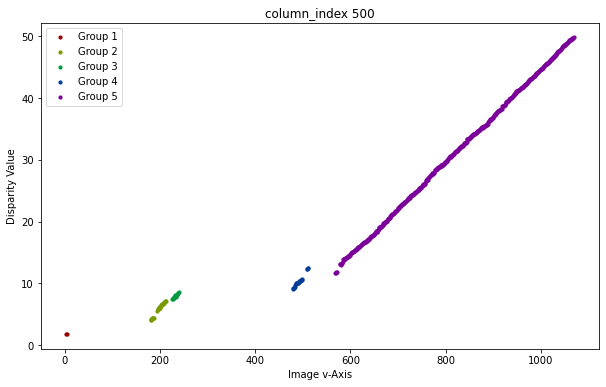

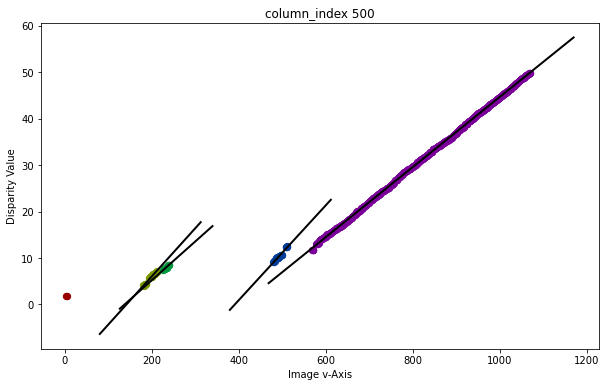

In [271]:
""" end = len(indexListHorCol)-1
count=0
limit=1
for i, point in enumerate(indexListHorCol):
    if(i >=end):
        break
    next=indexListHorCol[i+1]
    if(point >= next-limit):
        print("TRUE for points: ",point, " and ",next )
        count+=1
    #print(point, " ", i)
print("TOtal: ", count, " of ", end+1) """

#---------------------------------------------------------------------------------------------------------------------------------------------------------------
# Grouping "adjacent" points (points within a certain number)
#---------------------------------------------------------------------------------------------------------------------------------------------------------------


# The limit for considering pixels to be adjacent
limit = 10

# Function to group indices based on adjacency within a certain limit
def group_indices(indices, limit):
    if not indices:
        return []
    
    # Sort the list of indices first
    sorted_indices = sorted(indices)
    
    # Initialize the list of groups with the first index
    groups = [[sorted_indices[0]]]
    
    # Iterate through the sorted indices starting from the second element
    for index in sorted_indices[1:]:
        # Check if the current index is within the limit of the last index in the last group
        if index - groups[-1][-1] <= limit:
            # If yes, append it to the last group
            groups[-1].append(index)
        else:
            # Otherwise, start a new group
            groups.append([index])
    
    return groups

# Group the indices
grouped_indices = group_indices(indexListHorCol, limit)

# Print the grouped indices
print("Grouped indices:")
for group in grouped_indices:
    print(group)
print("Length ",len(grouped_indices))

# Generate dark colors for the number of groups
colors = generate_dark_colors(len(grouped_indices))

#---------------------------------------------------------------------------------------------------------------------------------------------------------------
# Plotting the grouped points together
#---------------------------------------------------------------------------------------------------------------------------------------------------------------


# Plotting
plt.figure(figsize=(10, 6))
for i, group in enumerate(grouped_indices):
    # Extract y-values and column_data for each group
    group_y_values = [y_values[idx] for idx in group]
    group_column_data = [column_data[idx] for idx in group]
    
    """ # Generate a color for each group
    color = plt.cm.jet(i / len(grouped_indices))  # Using the jet colormap """

    # Plot each group with a unique color
    plt.scatter(group_y_values, group_column_data, color=colors[i], s=10, label=f'Group {i+1}')

# You can also plot the overall data in the background if needed
#plt.plot(y_values, column_data, color='gray', alpha=0.5)
c = len(grouped_indices)+1/len(grouped_indices)
print("C ", c)
vertical_color = plt.cm.jet(c)
# Labeling and aesthetics and vertical values
#plt.scatter(highlighted_vertical_y_values, highlighted_vertical_column_data, color=vertical_color, s=10, zorder=1, label='Highlighted Points')
plt.xlabel('Image v-Axis')
plt.ylabel('Disparity Value')
plt.title('column_index ' +str(column_index))  # Change accordingly
plt.legend()
plt.show()

#---------------------------------------------------------------------------------------------------------------------------------------------------------------
# Linear regression and plotting
#---------------------------------------------------------------------------------------------------------------------------------------------------------------

min_size = 10

# Plotting the original scatter plot
plt.figure(figsize=(10, 6))
#---------------------------
# Original scatterplot
#---------------------------
for i, group in enumerate(grouped_indices):
    group_y_values = [y_values[idx] for idx in group]
    group_column_data = [column_data[idx] for idx in group]
    color = plt.cm.jet(i / len(grouped_indices))
    plt.scatter(group_y_values, group_column_data, color=colors[i], s=40, label=f'Group {i+1}')

#---------------------------
# Regression lines    
#---------------------------
# Performing linear regression and plotting lines
for group in grouped_indices:
    if len(group) >= min_size:
        # Extract y-values and column_data for each group
        group_y_values = np.array([y_values[idx] for idx in group])
        group_column_data = np.array([column_data[idx] for idx in group])

        # Linear regression
        A = np.vstack([group_y_values, np.ones(len(group_y_values))]).T
        m, c = np.linalg.lstsq(A, group_column_data, rcond=None)[0]

        # Define the extended line range
        extended_start = min(group_y_values) - 100  # Extend 5 units to the left
        extended_end = max(group_y_values) + 100   # Extend 5 units to the right
        extended_y_values = np.array([extended_start, extended_end])

        # Plotting the regression line
        plt.plot(extended_y_values, m * extended_y_values + c, color='black', linewidth=2)

# Labeling and aesthetics
plt.xlabel('Image v-Axis')
plt.ylabel('Disparity Value')
plt.title('column_index ' +str(column_index))  # Change accordinglyplt.legend()
plt.show()



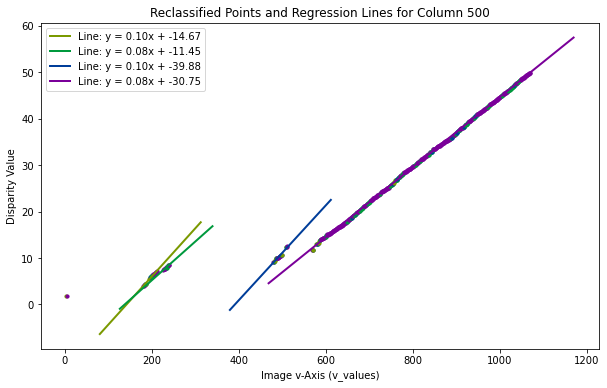

In [272]:

# Initialize list to store line equations and their colors
line_equations = []
plot_linear_regression_lines = True

fig_size_multiplier= 1

# Perform linear regression and store the results
plt.figure(figsize=(10*fig_size_multiplier, 6*fig_size_multiplier))
for i, group in enumerate(grouped_indices):
    if len(group) >= min_size:
        group_y_values = np.array([y_values[idx] for idx in group])
        group_column_data = np.array([column_data[idx] for idx in group])

        # Linear regression
        A = np.vstack([group_y_values, np.ones(len(group_y_values))]).T
        m, c = np.linalg.lstsq(A, group_column_data, rcond=None)[0]

        # Store the line equations along with their respective colors
        line_equations.append(((m, c), colors[i]))

        # Define the range for line extension
        extended_start = min(group_y_values) - 100
        extended_end = max(group_y_values) + 100
        extended_y_values = np.array([extended_start, extended_end])

        # Plot each regression line
        if(plot_linear_regression_lines):
            plt.plot(extended_y_values, m * extended_y_values + c, color=colors[i], linewidth=2, label=f'Line: y = {m:.2f}x + {c:.2f}')

# Reclassify each point and plot them
reclassified_points = []
for idx, v_value in enumerate(indexListHorCol):
    u_value = column_index  # u_value is the column_index for all points
    disparity = column_data[v_value]
    derivative = horizontal_column_derivative_list[idx]  # corresponding derivative value for this v_value

    # Find the line with the minimum slope difference and get its associated color
    closest_line, line_color = min(line_equations, key=lambda line: abs(line[0][0] - derivative))

    # Store reclassified points with their corresponding color
    reclassified_points.append((u_value, v_value, disparity, derivative, line_color))

    # Plot each point with the color of the closest regression line
    plt.scatter(v_value, disparity, color=line_color, s=10)  # Plot with the color of the closest regression line

plt.xlabel('Image v-Axis (v_values)')
plt.ylabel('Disparity Value')
plt.title(f'Reclassified Points and Regression Lines for Column {column_index}')
plt.legend()
plt.show()

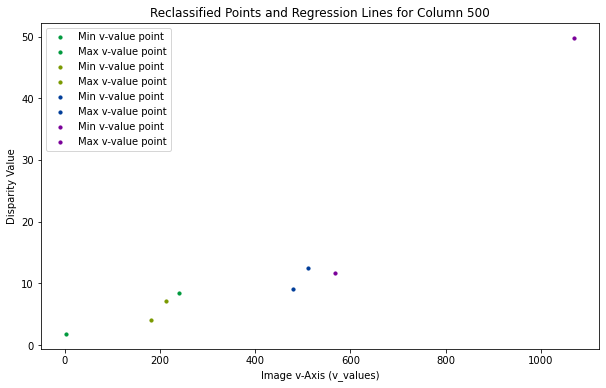

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


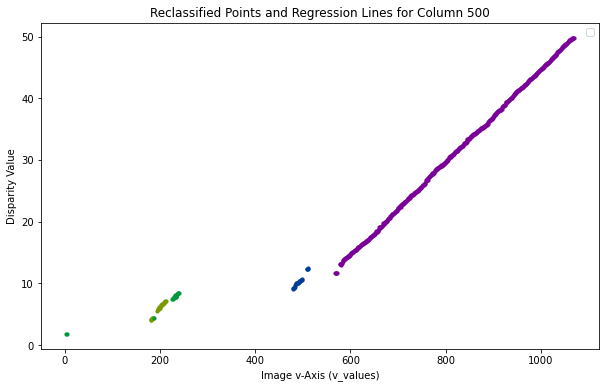

In [349]:

# Initialize list to store line equations and their colors
line_equations = []
plot_linear_regression_lines = False


# Perform linear regression and store the results
plt.figure(figsize=(10, 6))
for i, group in enumerate(grouped_indices):
    if len(group) >= min_size:
        group_y_values = np.array([y_values[idx] for idx in group])
        group_column_data = np.array([column_data[idx] for idx in group])

        # Linear regression
        A = np.vstack([group_y_values, np.ones(len(group_y_values))]).T
        m, c = np.linalg.lstsq(A, group_column_data, rcond=None)[0]

        # Store the line equations along with their respective colors
        line_equations.append(((m, c), colors[i]))

        # Define the range for line extension
        extended_start = min(group_y_values) - 100
        extended_end = max(group_y_values) + 100
        extended_y_values = np.array([extended_start, extended_end])

        # Plot each regression line
        if(plot_linear_regression_lines):
            plt.plot(extended_y_values, m * extended_y_values + c, color=colors[i], linewidth=2, label=f'Line: y = {m:.2f}x + {c:.2f}')


# Initialize storage for the edge values for each line
edge_points = {}  # Will map line (slope, intercept) to its min and max v-value points

# Initialize reclassified points list
reclassified_points = []

for idx, v_value in enumerate(indexListHorCol):
    u_value = column_index  # u_value is the column_index for all points
    disparity = column_data[v_value]  # Corrected to use index directly

    # Find the line with the minimum perpendicular distance to the point
    def distance_to_line(line):
        m, c = line[0]
        return abs(m * v_value - disparity + c) / np.sqrt(m**2 + 1)
    
    closest_line, line_color = min(line_equations, key=lambda line: distance_to_line(line))

    # Update edge points dictionary
    if closest_line not in edge_points:
        edge_points[closest_line] = {
            'min_v': (float('inf'), None),  # Store (v_value, point, color)
            'max_v': (float('-inf'), None)  # Store (v_value, point, color)
        }

    # Check for min or max v-values
    if v_value < edge_points[closest_line]['min_v'][0]:
        edge_points[closest_line]['min_v'] = (v_value, (u_value, v_value, disparity), line_color)
    if v_value > edge_points[closest_line]['max_v'][0]:
        edge_points[closest_line]['max_v'] = (v_value, (u_value, v_value, disparity), line_color)

    # Store reclassified points with their corresponding color for other uses
    reclassified_points.append((u_value, v_value, disparity, closest_line, line_color))

# Plot edge points
for line_info in edge_points.values():
    min_v_point = line_info['min_v']
    max_v_point = line_info['max_v']
    if min_v_point[1] is not None:  # Check if an actual point was stored
        plt.scatter(min_v_point[1][1], min_v_point[1][2], color=min_v_point[2], s=10, label='Min v-value point')
    if max_v_point[1] is not None:
        plt.scatter(max_v_point[1][1], max_v_point[1][2], color=max_v_point[2], s=10, label='Max v-value point')

plt.xlabel('Image v-Axis (v_values)')
plt.ylabel('Disparity Value')
plt.title(f'Reclassified Points and Regression Lines for Column {column_index}')
plt.legend()
plt.show()


to_do_or_not_this_plot = True
if(to_do_or_not_this_plot):
    # Reclassify each point and plot them
    plt.figure(figsize=(10,6))
    reclassified_points = []
    for idx, v_value in enumerate(indexListHorCol):
        u_value = column_index  # u_value is the column_index for all points
        disparity = column_data[v_value]  # Corrected to use index directly

        # Find the line with the minimum perpendicular distance to the point
        def distance_to_line(line):
            m, c = line[0]
            return abs(m * v_value - disparity + c) / np.sqrt(m**2 + 1)
        
        closest_line, line_color = min(line_equations, key=lambda line: distance_to_line(line))

        # Store reclassified points with their corresponding color
        reclassified_points.append((u_value, v_value, disparity, closest_line))

        # Plot each point with the color of the closest regression line
        plt.scatter(v_value, disparity, color=line_color, s=10)  # Plot with the color of the closest regression line

    plt.xlabel('Image v-Axis (v_values)')
    plt.ylabel('Disparity Value')
    plt.title(f'Reclassified Points and Regression Lines for Column {column_index}')
    plt.legend()
    plt.show()

## Alt over funker bra!


### Fullt kjør

532


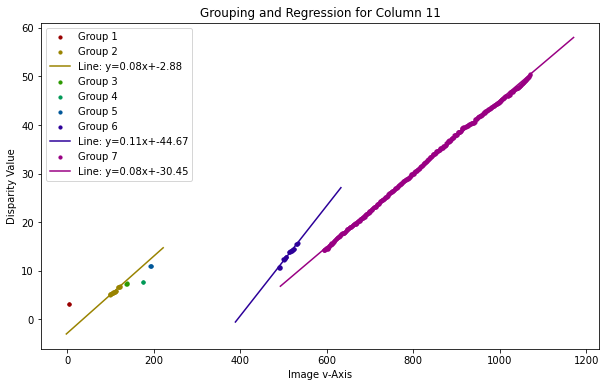

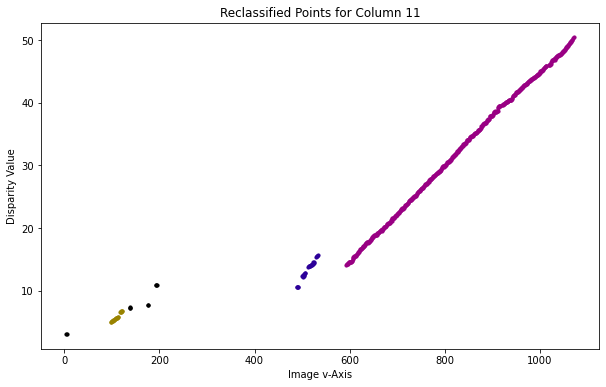

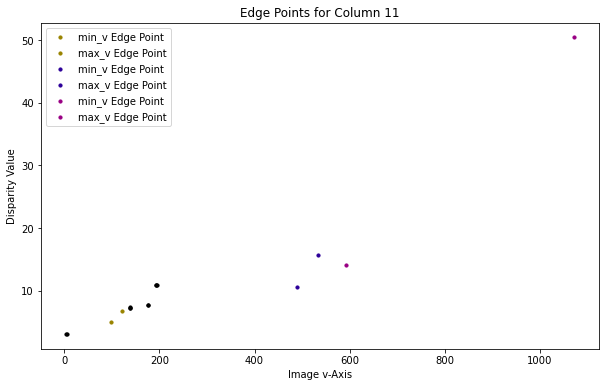

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


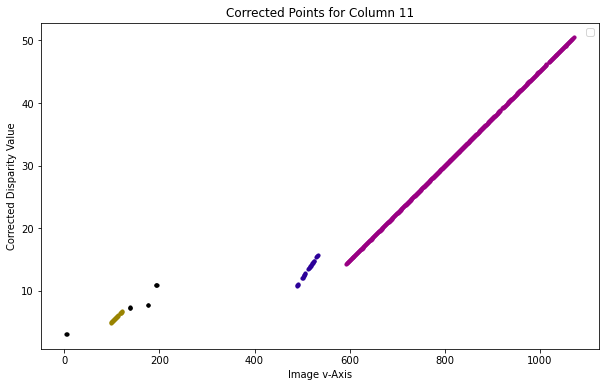

" [[0.11635876, 1.8007812, 3, 500, 'horizontal'], [0.06735921, 1.8046875, 4, 500, 'horizontal'] "

In [360]:
def group_indices(indices, limit=10):
    if not indices:
        return []
    sorted_indices = sorted(indices)
    groups = [[sorted_indices[0]]]
    for index in sorted_indices[1:]:
        if index - groups[-1][-1] <= limit:
            groups[-1].append(index)
        else:
            groups.append([index])
    return groups

def perform_linear_regression(groups, y_values, column_data):
    line_equations = []
    min_size = 10  # Minimum group size to perform regression
    for group in groups:
        if len(group) >= min_size:
            group_y_values = np.array([y_values[idx] for idx in group])
            group_column_data = np.array([column_data[idx] for idx in group])
            A = np.vstack([group_y_values, np.ones(len(group_y_values))]).T
            m, c = np.linalg.lstsq(A, group_column_data, rcond=None)[0]
            line_equations.append((m, c))
        else:
            line_equations.append(None)
    return line_equations

def perform_linear_regressionV2(groups, y_values, column_data):
    line_equations = []
    edge_boundaries = []  # List to store edge boundaries for each group
    min_size = 10
    for group in groups:
        if len(group) >= min_size:
            group_y_values = np.array([y_values[idx] for idx in group])
            group_column_data = np.array([column_data[idx] for idx in group])
            A = np.vstack([group_y_values, np.ones(len(group_y_values))]).T
            m, c = np.linalg.lstsq(A, group_column_data, rcond=None)[0]
            line_equations.append((m, c))
            # Store the min and max v-values for the group
            edge_boundaries.append((min(group_y_values), max(group_y_values)))
        else:
            line_equations.append(None)
            edge_boundaries.append(None)
    return line_equations, edge_boundaries


""" def reclassify_points_and_identify_edges(indexList, column_data, line_equations, column_index):
    reclassified_points = []
    edge_points = {}
    for idx, v_value in enumerate(indexList):
        u_value = column_index
        disparity = column_data[v_value]
        def distance_to_line(line):
            m, c = line
            return abs(m * v_value - disparity + c) / np.sqrt(m**2 + 1)
        
        closest_line = min((line for line in line_equations if line is not None), key=distance_to_line)
        reclassified_points.append((u_value, v_value, disparity, closest_line))

        # Update edge points
        if closest_line not in edge_points:
            edge_points[closest_line] = {'min_v': (float('inf'), None), 'max_v': (float('-inf'), None)}
        if v_value < edge_points[closest_line]['min_v'][0]:
            edge_points[closest_line]['min_v'] = (v_value, (u_value, v_value, disparity))
        if v_value > edge_points[closest_line]['max_v'][0]:
            edge_points[closest_line]['max_v'] = (v_value, (u_value, v_value, disparity))
    return reclassified_points, edge_points
 """

def reclassify_points_and_identify_edges(indexList, column_data, line_equations, column_index):
    reclassified_points = []
    edge_points = {}
    corrected_points = []  # New list to store corrected points

    for idx, v_value in enumerate(indexList):
        u_value = column_index
        disparity = column_data[v_value]
        
        def distance_to_line(line):
            m, c = line
            return abs(m * v_value - disparity + c) / np.sqrt(m**2 + 1)
        
        closest_line = min((line for line in line_equations if line is not None), key=distance_to_line)
        reclassified_points.append((u_value, v_value, disparity, closest_line))

        # Correct the disparity value so that it lies on the regression line
        if closest_line is not None:
            m, c = closest_line
            corrected_disparity = m * v_value + c  # y = mx + c
            corrected_points.append((u_value, v_value, corrected_disparity, closest_line))

        # Update edge points
        if closest_line not in edge_points:
            edge_points[closest_line] = {'min_v': (float('inf'), None), 'max_v': (float('-inf'), None)}
        if v_value < edge_points[closest_line]['min_v'][0]:
            edge_points[closest_line]['min_v'] = (v_value, (u_value, v_value, disparity))
        if v_value > edge_points[closest_line]['max_v'][0]:
            edge_points[closest_line]['max_v'] = (v_value, (u_value, v_value, disparity))

    return reclassified_points, edge_points, corrected_points

def reclassify_points_and_identify_edgesV2(indexList, column_data, line_equations, edge_boundaries, column_index):
    reclassified_points = []
    edge_points = {}
    corrected_points = []  # New list to store corrected points
    unknown_points = []

    for idx, v_value in enumerate(indexList):
        u_value = column_index
        disparity = column_data[v_value]
        
        # Function to calculate distance to line
        def distance_to_line(line):
            m, c = line
            return abs(m * v_value - disparity + c) / np.sqrt(m**2 + 1)
        
        # Create a sorted list of lines based on their distance to the point
        valid_lines = [(line, boundaries) for line, boundaries in zip(line_equations, edge_boundaries) if line is not None and boundaries is not None]
        sorted_lines = sorted(valid_lines, key=lambda x: distance_to_line(x[0]))

        # Try to classify the point to the first valid line within boundaries
        classified = False
        for line, (min_v, max_v) in sorted_lines:
            if min_v <= v_value <= max_v:
                reclassified_points.append((u_value, v_value, disparity, line))
                m, c = line
                corrected_disparity = m * v_value + c  # y = mx + c
                corrected_points.append((u_value, v_value, corrected_disparity, line))
                classified = True
                break

        # Update edge points if the point was classified
        if classified:
            if line not in edge_points:
                edge_points[line] = {'min_v': (float('inf'), None), 'max_v': (float('-inf'), None)}
            if v_value < edge_points[line]['min_v'][0]:
                edge_points[line]['min_v'] = (v_value, (u_value, v_value, disparity))
            if v_value > edge_points[line]['max_v'][0]:
                edge_points[line]['max_v'] = (v_value, (u_value, v_value, disparity))
        else:
            # If no valid line was found to classify the point, add it to the unknown points list
            unknown_points.append((u_value, v_value, disparity, "unknown"))

    return reclassified_points, edge_points, corrected_points, unknown_points

def reclassify_points_and_identify_edgesV3(indexList, column_data, line_equations, edge_boundaries, column_index):
    reclassified_points = []
    edge_points = {}
    corrected_points = []  # List to store corrected points
    unknown_points = []  # List to store points that fall outside any line boundaries

    for idx, v_value in enumerate(indexList):
        u_value = column_index
        disparity = column_data[v_value]
        
        # Function to calculate distance to line
        def distance_to_line(line):
            m, c = line
            return abs(m * v_value - disparity + c) / np.sqrt(m**2 + 1)
        
        # Find the closest line among those with valid boundaries
        valid_lines = [(line, boundaries) for line, boundaries in zip(line_equations, edge_boundaries) if line is not None and boundaries is not None]
        sorted_lines = sorted(valid_lines, key=lambda x: distance_to_line(x[0]))

        # Initialize flag to check if the point has been classified
        classified = False
        for line, (min_v, max_v) in sorted_lines:
            if min_v <= v_value <= max_v:
                reclassified_points.append((u_value, v_value, disparity, line))
                m, c = line
                corrected_disparity = m * v_value + c  # y = mx + c
                corrected_points.append((u_value, v_value, corrected_disparity, line))
                classified = True
                break

        # If no line includes the point within its boundary
        if not classified:
            unknown_points.append((u_value, v_value, disparity))

        # Update edge points
        if classified and line:
            if line not in edge_points:
                edge_points[line] = {'min_v': (float('inf'), None), 'max_v': (float('-inf'), None)}
            if v_value < edge_points[line]['min_v'][0]:
                edge_points[line]['min_v'] = (v_value, (u_value, v_value, disparity))
            if v_value > edge_points[line]['max_v'][0]:
                edge_points[line]['max_v'] = (v_value, (u_value, v_value, disparity))

    return reclassified_points, edge_points, corrected_points, unknown_points

size_of_fig=(10, 6)
# Main function to process column data
def process_column(column_index, plot=False, size_of_fig=size_of_fig, version=1):
    column_data = surface_splitting_disparity_image[:, column_index]
    y_values = range(len(column_data))

    #print(horizontal_column_object_list)
    # Generate index list and other preprocessing as per actual data handling

    horizontal_column_object_list = single_column_list_generator(column_index, True)
    #print(len(horizontal_column_object_list))
    indexListHorCol = generate_index_list(horizontal_column_object_list)

    #print("Length of indexlist: ", len(indexListHorCol))

    groups = group_indices(indexListHorCol)
    colors = generate_dark_colors(len(groups))

    if(version==2):
        # Version 2
        line_equations, edge_boundaries = perform_linear_regressionV2(groups, list(y_values), column_data)
        reclassified_points, edge_points, corrected_points, unknown_points = reclassify_points_and_identify_edgesV2(indexListHorCol, column_data, line_equations, edge_boundaries, column_index)
    elif(version==3):
        # Version 3
        line_equations, edge_boundaries = perform_linear_regressionV2(groups, list(y_values), column_data)
        reclassified_points, edge_points, corrected_points, unknown_points = reclassify_points_and_identify_edgesV3(indexListHorCol, column_data, line_equations, edge_boundaries, column_index)
    else:
        # Version 1
        line_equations = perform_linear_regression(groups, list(y_values), column_data)
        reclassified_points, edge_points, corrected_points = reclassify_points_and_identify_edges(indexListHorCol, column_data, line_equations, column_index)

    if plot:
        """ # Plot 1: Grouping and Regression
        plt.figure(figsize=size_of_fig)
        for i, group in enumerate(groups):
            if group:
                group_y_values = [y_values[idx] for idx in group]
                group_column_data = [column_data[idx] for idx in group]
                plt.scatter(group_y_values, group_column_data, color=colors[i], s=10, label=f'Group {i+1}')
                if line_equations[i]:
                    m, c = line_equations[i]
                    extended_x = np.linspace(min(y_values), max(y_values), 400)
                    plt.plot(extended_x, m * extended_x + c, color=colors[i])
        plt.xlabel('Image v-Axis')
        plt.ylabel('Disparity Value')
        plt.title('Grouping and Regression for Column ' + str(column_index))
        plt.legend()
        plt.show()
        """
        # Plot 1: Grouping and Regression
        plt.figure(figsize=size_of_fig)
        for i, group in enumerate(groups):
            if group:
                group_y_values = [y_values[idx] for idx in group]
                group_column_data = [column_data[idx] for idx in group]
                plt.scatter(group_y_values, group_column_data, color=colors[i], s=10, label=f'Group {i+1}')
                
                if line_equations[i]:
                    m, c = line_equations[i]
                    # Calculate extended x values but make them shorter than the full range
                    extended_start = min(group_y_values) - 100  # you can adjust these values to control the length
                    extended_end = max(group_y_values) + 100   # likewise, adjust here for the end
                    extended_x = np.linspace(extended_start, extended_end, 400)
                    plt.plot(extended_x, m * extended_x + c, color=colors[i], label=f'Line: y={m:.2f}x+{c:.2f}')

        plt.xlabel('Image v-Axis')
        plt.ylabel('Disparity Value')
        plt.title('Grouping and Regression for Column ' + str(column_index))
        plt.legend()
        plt.show()

        # Plot 2: Reclassified Points
        line_to_color = {line: colors[i] for i, line in enumerate(line_equations) if line is not None}

        plt.figure(figsize=(10, 6))
        for point in reclassified_points:
            u_value, v_value, disparity, line = point
            if line in line_to_color:
                color = line_to_color[line]
                plt.scatter(v_value, disparity, color=color, s=10)  # Use the color mapped to the line
        if(version==2 or version == 3):
            for point in unknown_points:
                u_value, v_value, disparity, line = point
                plt.scatter(v_value, disparity, color='black', s=10)

        plt.xlabel('Image v-Axis')
        plt.ylabel('Disparity Value')
        plt.title('Reclassified Points for Column ' + str(column_index))
        plt.show()

        # Plot 3: Edge Points
        plt.figure(figsize=size_of_fig)
        line_to_color = {line: colors[i] for i, line in enumerate(line_equations) if line is not None}
        for line, edge in edge_points.items():
            if line in line_to_color:
                color = line_to_color[line]  # Use the mapped color for the line
                for key, value in edge.items():
                    if value[1] is not None:
                        plt.scatter(value[1][1], value[1][2], color=color, s=10, label=f'{key} Edge Point')
        if(version==2 or version == 3):
            for point in unknown_points:
                u_value, v_value, disparity, line = point
                plt.scatter(v_value, disparity, color='black', s=10)
        plt.xlabel('Image v-Axis')
        plt.ylabel('Disparity Value')
        plt.title('Edge Points for Column ' + str(column_index))
        plt.legend()
        plt.show()

   
        # Plot corrected points as an additional plot or integrated into one of the existing plots
        plt.figure(figsize=size_of_fig)
        for point in corrected_points:
            u_value, v_value, disparity, line = point
            if line in line_to_color:
                color = line_to_color[line]
                plt.scatter(v_value, disparity, color=color, s=10) 
        if(version==2 or version == 3):
            for point in unknown_points:
                u_value, v_value, disparity, line = point
                plt.scatter(v_value, disparity, color='black', s=10)
        plt.xlabel('Image v-Axis')
        plt.ylabel('Corrected Disparity Value')
        plt.title('Corrected Points for Column ' + str(column_index))
        plt.legend()
        plt.show()

    if(version == 2 or version == 3):
        return reclassified_points, edge_points, corrected_points, unknown_points
    return reclassified_points, edge_points, corrected_points

def group_corrected_points_by_line(corrected_points, unknown_points):
    line_groups = {}  # Dictionary to hold the groups

    for point in corrected_points:
        u_value, v_value, corrected_disparity, line = point
        line_key = tuple(line)  # Convert the line equation to a tuple to use as a dictionary key

        if line_key not in line_groups:
            line_groups[line_key] = []
        line_groups[line_key].append([u_value, v_value, corrected_disparity, line])

    # Convert dictionary to list of lists
    grouped_lists = list(line_groups.values())
    grouped_lists.append([unknown_points])
    return grouped_lists

def group_corrected_points_by_line_no_unknowns(corrected_points):
    line_groups = {}  # Dictionary to hold the groups

    for point in corrected_points:
        u_value, v_value, corrected_disparity, line = point
        line_key = tuple(line)  # Convert the line equation to a tuple to use as a dictionary key

        if line_key not in line_groups:
            line_groups[line_key] = []
        line_groups[line_key].append([u_value, v_value, corrected_disparity, line])

    # Convert dictionary to list of lists
    grouped_lists = list(line_groups.values())
    return grouped_lists

def group_corrected_points_by_lineV2(corrected_points, unknown_points):
    line_groups = {}
    for point in corrected_points:
        u_value, v_value, corrected_disparity, line = point
        line_key = tuple(line)  # Use the line equation as the dictionary key
        if line_key not in line_groups:
            line_groups[line_key] = []
        line_groups[line_key].append([u_value, v_value, corrected_disparity])

    # Handle unknown points
    unknown_key = ('unknown',)
    line_groups[unknown_key] = []
    for point in unknown_points:
        u_value, v_value, disparity, _ = point
        line_groups[unknown_key].append([u_value, v_value, disparity])

    return list(line_groups.values())

""" 
for i, obj in enumerate(vertical_Obj_List):
    if(labels[i] == 0):
        obj[3] = "vertical1"
    elif(labels[i] == 1):
        obj[3] = "vertical2"
    elif(labels[i] == 2):
        obj[3] = "vertical3"
    elif(labels[i] == 3):
        obj[3] = "vertical4"
    else:
        obj[3] = "Vertical5"

new_class_map = np.copy(classification_map)

for i, obj in enumerate(vertical_Obj_List):
    i = obj[1]
    j= obj[2]
    new_class_map[i,j] = obj[3] 
"""


horizontal_label_list = ['horizontal1', 'horizontal2', 'horizontal3', 'horizontal4', 'horizontal5', 'horizontal6']

def new_column_object_list_generator(grouped_corrected_points, new_full_object_list=[]):

    new_column_object_list = []

    last_group = len(grouped_corrected_points)-1
    #print(last_group)

    for i, group in enumerate(grouped_corrected_points):
        for point in group:
            if(i>= len(horizontal_label_list) or (i ==last_group)):
                point.append('unknown')
            else:
                point.append(horizontal_label_list[i])
            #print("Point: ", point)
            new_column_object_list.append(point)
            new_full_object_list.append(point)

    return new_column_object_list, new_full_object_list

# Example of how to call this function
current_column_index = 11  # Example column index
reclassified_points_initial, edge_points_initial, corrected_points, unknown_points =  process_column(current_column_index, plot=True, version=2)

grouped_reclassified_points = group_corrected_points_by_lineV2(reclassified_points_initial, unknown_points)
relabeled_horizontals, _ = new_column_object_list_generator(grouped_reclassified_points)


grouped_corrected_points = group_corrected_points_by_lineV2(corrected_points, unknown_points)
newest_test_list, disregarded= new_column_object_list_generator(grouped_corrected_points)

#print("Length ",len(newest_test_list))


""" for i, group in enumerate(grouped_corrected_points):
    print("index: ", i)
    print("Group:", group) """
""" [[0.11635876, 1.8007812, 3, 500, 'horizontal'], [0.06735921, 1.8046875, 4, 500, 'horizontal'], """
""" [[0.11635876, 1.8007812, 3, 500, 'horizontal'], [0.06735921, 1.8046875, 4, 500, 'horizontal'] """

In [361]:
# Takes 15 secs to run
def all_columns_full_horizontal_object_list_generator(surface_splitting_disparity_image, plot=False, version =2):
    all_columns_full_horizontal_object_list = []
    
    # Assume there is a known number of columns
    total_columns = surface_splitting_disparity_image.shape[1]

    for current_column_index in range(total_columns):
        if(version==2):
            reclassified_points_initial, edge_points_initial, corrected_points, unknown_points =  process_column(current_column_index, plot=False, version=version)
            grouped_corrected_points = group_corrected_points_by_lineV2(corrected_points, unknown_points)
        elif(version==3):
            reclassified_points_initial, edge_points_initial, corrected_points, unknown_points =  process_column(current_column_index, plot=False, version=version)
            grouped_corrected_points = group_corrected_points_by_lineV2(corrected_points, unknown_points)
        else:
            reclassified_points_initial, edge_points_initial, corrected_points =  process_column(current_column_index, plot=False, version=1)
            grouped_corrected_points = group_corrected_points_by_line_no_unknowns(corrected_points)

        newest_test_list, all_columns_full_horizontal_object_list = new_column_object_list_generator(grouped_corrected_points, all_columns_full_horizontal_object_list)
        
    return all_columns_full_horizontal_object_list

all_columns_full_horizontal_object_list = all_columns_full_horizontal_object_list_generator(surface_splitting_disparity_image, version=2)
print("Length all columns",len(all_columns_full_horizontal_object_list))
print("Length obj list", len(horizontal_Obj_List))

551
540
550
559
556
548
547
540
533
528
528
532
527
525
529
532
536
541
538
542
541
544
546
549
550
549
549
548
547
543
542
540
539
538
537
539
537
540
539
529
527
523
524
522
520
521
524
522
520
518
514
513
514
513
508
507
506
505
504
504
502
499
502
499
497
496
495
496
497
498
501
505
512
512
512
513
516
516
514
518
523
528
527
524
518
519
513
516
517
517
516
515
514
512
506
510
509
508
507
513
510
509
509
511
512
509
509
510
510
510
512
512
509
509
510
511
513
515
512
514
513
512
515
514
513
515
517
517
518
518
515
517
517
515
515
514
515
515
515
513
512
512
513
511
512
510
509
509
508
508
510
515
522
526
528
527
527
523
526
521
525
524
525
525
526
529
527
527
523
521
520
522
522
523
523
526
522
521
522
522
523
522
520
519
518
519
518
519
519
520
521
520
525
529
526
527
525
524
529
525
526
526
529
529
529
529
530
529
533
532
531
533
527
527
522
520
519
523
517
517
520
521
517
511
511
514
516
517
517
518
518
517
518
524
528
528
529
530
531
532
531
537
534
534
532
531
529
529
529
534


(1080, 1920)
[['unknown' 'unknown' 'unknown' ... 'unknown' 'unknown' 'unknown']
 ['unknown' 'unknown' 'unknown' ... 'unknown' 'unknown' 'unknown']
 ['unknown' 'unknown' 'unknown' ... 'unknown' 'unknown' 'unknown']
 ...
 ['unknown' 'unknown' 'unknown' ... 'unknown' 'unknown' 'unknown']
 ['unknown' 'unknown' 'unknown' ... 'unknown' 'unknown' 'unknown']
 ['unknown' 'unknown' 'unknown' ... 'unknown' 'unknown' 'unknown']]
Length new 1082880
Length original 1020833
horizontal4


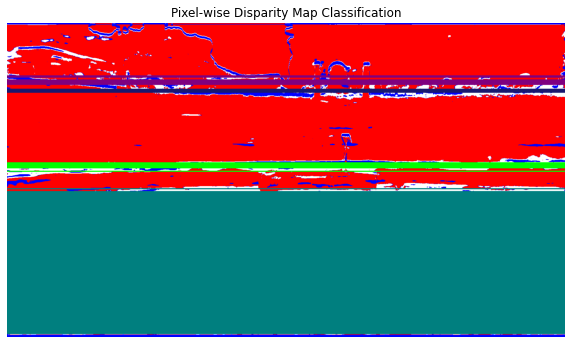

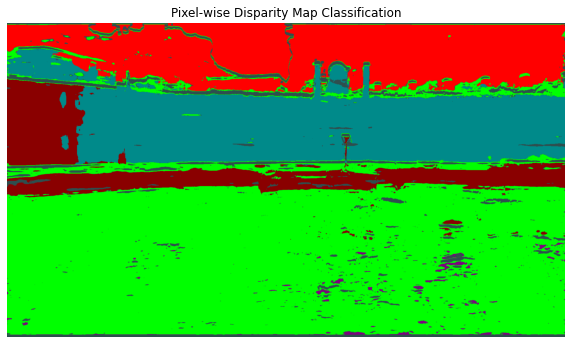

In [287]:
horizontal_test_class_map = np.copy(classification_map)

print((horizontal_test_class_map.shape))

print(horizontal_test_class_map)

print("Length new", len(all_columns_full_horizontal_object_list))
print("Length original",len(horizontal_Obj_List))

check_if_horizontal = False

for index, obj in enumerate(all_columns_full_horizontal_object_list):
    i = obj[1]
    j= obj[0]
    lab = obj[3]
    #print("i: ", i, " j: ", j, " label: ", lab)
    if(check_if_horizontal):
        if(horizontal_test_class_map[i,j] =='horizontal'):
            horizontal_test_class_map[i,j] = obj[3]
    else:
        horizontal_test_class_map[i,j] = obj[3]
    #print(horizontal_test_class_map[i,j])


print(horizontal_test_class_map[1069][1])

"""  
Dark_Red = [139/256, 0,0]
Pure_Red = [1,0,0]
Navy_Blue= [0, 0,128/256]
Pure_Blue = [0,0,1]
Dark_Slate_Gray=[47/256, 79/256, 79/256]
Chocolate= [210/256, 105/256, 30/256]
Saddle_Brown= [139/256, 69/256, 19/256]
Firebrick =[178/256, 34/256, 34/256]
Dark_Goldenrod=[184/256, 134/256, 11/256]
Midnight_Blue=[25/256, 25/256, 112/256]
Indigo =[75/256, 0, 130/256]
Sienna=[160/256, 82/256, 45/256]
Purple = [128/256,0 , 128/256]
Black = [0,0,0]
White = [1,1,1]
#Greens
Olive_Green= [85/256, 107/256, 47/256]
Forest_Green= [34/256, 139/256, 34/256]
Pure_Green= [0, 1, 0]
Teal= [0, 128/256, 128/256]
Dark_Cyan= [0, 139/256, 139/256]
Dark_Green= [0, 100/256, 0]

"""
Pure_Green= [0, 1, 0]
Pure_Red = [1,0,0]
Olive_Green= [85/256, 107/256, 47/256]
Forest_Green= [34/256, 139/256, 34/256]
Pure_Green= [0, 1, 0]
Teal= [0, 128/256, 128/256]
Dark_Cyan= [0, 139/256, 139/256]
Dark_Green= [0, 100/256, 0]
Pure_Blue = [0,0,1]
# Define colors for each classification
horisontalColorScheme = {
    'horizontal1': Purple,  # Navy blue  
    'horizontal2': Midnight_Blue,  # Pure red
    'horizontal3': Pure_Green,  # Purple
    'horizontal4': Teal,  # Cyan
    'horizontal5': Firebrick,
    'horizontal6': Dark_Green,
    'upright': Pure_Red,  # Red
    'unknown': Pure_Blue,  # Gray
    'undecided': Navy_Blue,
    'horizontal': White
}


# Create an empty array for the color-coded image
horizontal_color_coded_image = np.zeros((*horizontal_test_class_map.shape, 3))
#print(color_coded_image)


# Assign colors based on the classification in new_class_map
for label, color in horisontalColorScheme.items():
    # Find indices where the current label is present in new_class_map
    indices = np.where(horizontal_test_class_map == label)
    # Assign the corresponding color to these indices in the color-coded image
    horizontal_color_coded_image[indices] = color

#print(color_coded_image)
plt.figure(figsize=(10, 6))
plt.imshow(horizontal_color_coded_image)
plt.title('Pixel-wise Disparity Map Classification')
plt.axis('off')  # Hide the axes
plt.show() 
plt.figure(figsize=(10, 6))
plt.imshow(color_coded_image)
plt.title('Pixel-wise Disparity Map Classification')
plt.axis('off')  # Hide the axes
plt.show() 

In [292]:
print(horizontal_test_class_map.shape)
for i in range(horizontal_test_class_map.shape[1]):
    print(horizontal_test_class_map[200][i])


(1080, 1920)
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
horizontal1
hor

In [122]:
def process_all_columns_and_visualize(surface_splitting_disparity_image, plot=False):
    all_grouped_points = []
    number_of_lines = []
    
    # Assume there is a known number of columns
    total_columns = surface_splitting_disparity_image.shape[1]
    
    for current_column_index in range(total_columns):
        # Assuming process_column function properly handles version argument
        reclassified_points_initial, edge_points_initial, corrected_points, unknown_points = process_column(current_column_index, plot=False, version=2)
        grouped_corrected_points = group_corrected_points_by_lineV2(corrected_points, unknown_points)
        number_of_lines.append(len(grouped_corrected_points))
        # Append grouped points from this column to the master list
        all_grouped_points.extend(grouped_corrected_points)
        
        # Optionally plot each column's results
        if plot:
            plt.figure(figsize=(10, 6))  # Set reasonable figure size
            for group in grouped_corrected_points:
                x_vals = [p[1] for p in group]  # v_values
                y_vals = [p[2] for p in group]  # Disparities
                plt.scatter(x_vals, y_vals, label=f'Column {current_column_index}')
            plt.xlabel('v-Value')
            plt.ylabel('Disparity')
            plt.title('Grouped Corrected Points Across All Columns')
            plt.legend()
            plt.show()
    
    return all_grouped_points, number_of_lines

# Example of downsampling
def downsample_data(data, factor):
    # Downsample data by picking every 'factor' points
    return data[::factor]



# Denne under tar 8 min å kjøre
# Use the downsampled data for processing and visualization
#downsampled_data = downsample_data(surface_splitting_disparity_image, factor=10)
#all_grouped_points = process_all_columns_and_visualize(downsampled_data, plot=True)

all_grouped_points, number_of_lines = process_all_columns_and_visualize(surface_splitting_disparity_image, plot=False)

print(number_of_lines)

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

In [345]:
curr_i = 1000


print("Grouped points: ",len(all_grouped_points[curr_i]))
print("Actual  points: ", len(divided_horizontal_obj_list[curr_i]))

Grouped points:  27
Actual  points:  1895


In [ ]:
# Hjelpe metode allerede tatt i bruk ovenfor
# Kan slettes

print((corrected_points))
print(len(corrected_points))
print((unknown_points))

#print("index list hor col: ", indexListHorCol)

def group_corrected_points_by_line(corrected_points, unknown_points):
    line_groups = {}  # Dictionary to hold the groups

    for point in corrected_points:
        u_value, v_value, corrected_disparity, line = point
        line_key = tuple(line)  # Convert the line equation to a tuple to use as a dictionary key

        if line_key not in line_groups:
            line_groups[line_key] = []
        line_groups[line_key].append([u_value, v_value, corrected_disparity, line])

    # Convert dictionary to list of lists
    grouped_lists = list(line_groups.values())
    grouped_lists.append([unknown_points])
    return grouped_lists

grouped_corrected_points = group_corrected_points_by_line(corrected_points)
for group in grouped_corrected_points:
    print("Group:", group)

print(len(grouped_corrected_points))

[(1600, 3, 2.4375, (0, 0)), (1600, 4, 2.4609375, (0, 0)), (1600, 180, 3.8399522306652147, (0.029849211875353172, -1.5329059068983564)), (1600, 181, 3.869801442540568, (0.029849211875353172, -1.5329059068983564)), (1600, 182, 3.8996506544159213, (0.029849211875353172, -1.5329059068983564)), (1600, 183, 3.9294998662912746, (0.029849211875353172, -1.5329059068983564)), (1600, 184, 3.959349078166627, (0.029849211875353172, -1.5329059068983564)), (1600, 185, 3.9891982900419802, (0.029849211875353172, -1.5329059068983564)), (1600, 186, 4.019047501917333, (0.029849211875353172, -1.5329059068983564)), (1600, 187, 4.048896713792686, (0.029849211875353172, -1.5329059068983564)), (1600, 194, 4.257841196920159, (0.029849211875353172, -1.5329059068983564)), (1600, 195, 4.2876904087955126, (0.029849211875353172, -1.5329059068983564)), (1600, 196, 4.317539620670866, (0.029849211875353172, -1.5329059068983564)), (1600, 197, 4.347388832546219, (0.029849211875353172, -1.5329059068983564)), (1600, 198, 4

### Printing out all edge points of all columns
#### Takes 6 minutes to run

Column:  0
Column:  1
Column:  2
Column:  3
Column:  4
Column:  5
Column:  6
Column:  7
Column:  8
Column:  9
Column:  10
Column:  11
Column:  12
Column:  13
Column:  14
Column:  15
Column:  16
Column:  17
Column:  18
Column:  19
Column:  20
Column:  21
Column:  22
Column:  23
Column:  24
Column:  25
Column:  26
Column:  27
Column:  28
Column:  29
Column:  30
Column:  31
Column:  32
Column:  33
Column:  34
Column:  35
Column:  36
Column:  37
Column:  38
Column:  39
Column:  40
Column:  41
Column:  42
Column:  43
Column:  44
Column:  45
Column:  46
Column:  47
Column:  48
Column:  49
Column:  50
Column:  51
Column:  52
Column:  53
Column:  54
Column:  55
Column:  56
Column:  57
Column:  58
Column:  59
Column:  60
Column:  61
Column:  62
Column:  63
Column:  64
Column:  65
Column:  66
Column:  67
Column:  68
Column:  69
Column:  70
Column:  71
Column:  72
Column:  73
Column:  74
Column:  75
Column:  76
Column:  77
Column:  78
Column:  79
Column:  80
Column:  81
Column:  82
Column:  83
Co

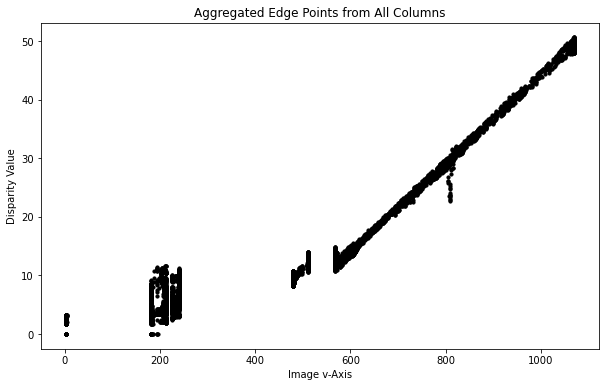

In [ ]:

def process_all_columns(surface_splitting_disparity_image, plot_each_column=False, plot_aggregated_edges=True):
    total_columns = surface_splitting_disparity_image.shape[1]
    all_edge_points = []

    # Process each column
    if plot_aggregated_edges:
        plt.figure(figsize=(10,6))
    for column_index in range(total_columns):
        print("Column: ", column_index)
        _, edge_points = process_column(column_index, plot=plot_each_column)
        for line, edge in edge_points.items():
            for key, value in edge.items():
                if value[1] is not None:
                    all_edge_points.append((value[1][1], value[1][2]))  # Store (v_value, disparity)
                    if plot_aggregated_edges:
                        plt.scatter(value[1][1], value[1][2], color='black', s=10) 
    if plot_aggregated_edges:
        plt.xlabel('Image v-Axis')
        plt.ylabel('Disparity Value')
        plt.title('Aggregated Edge Points from All Columns')
        plt.show()

    return all_edge_points

# Assuming surface_splitting_disparity_image is defined
# Example call
all_edge_points = process_all_columns(surface_splitting_disparity_image, plot_each_column=False, plot_aggregated_edges=False)

Length  5
Grouped indices:
[3, 4]
[180, 181, 182, 183, 184, 185, 186, 187, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212]
[226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239]
[479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 508, 509, 510, 511]
[568, 569, 570, 571, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 70

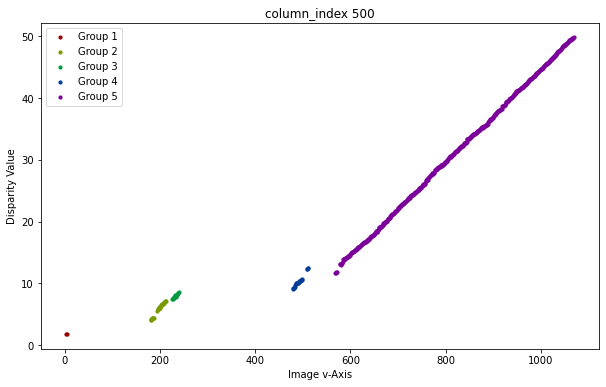

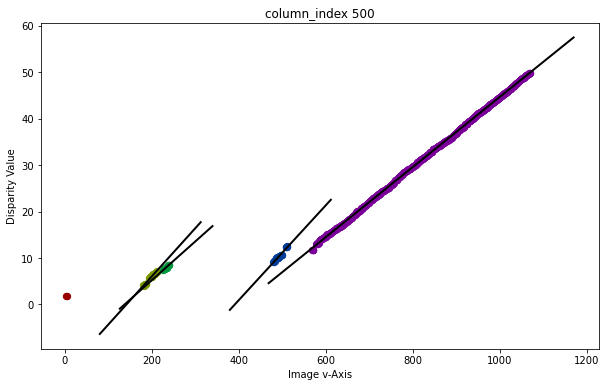

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


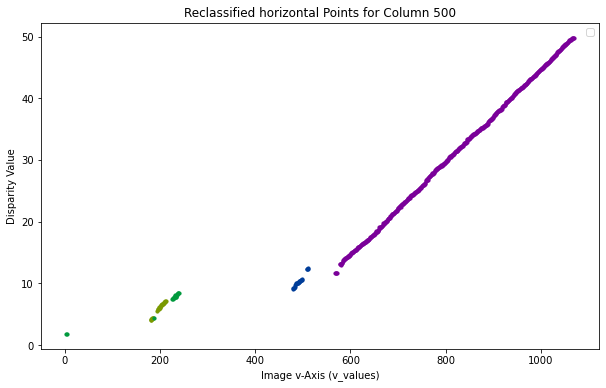

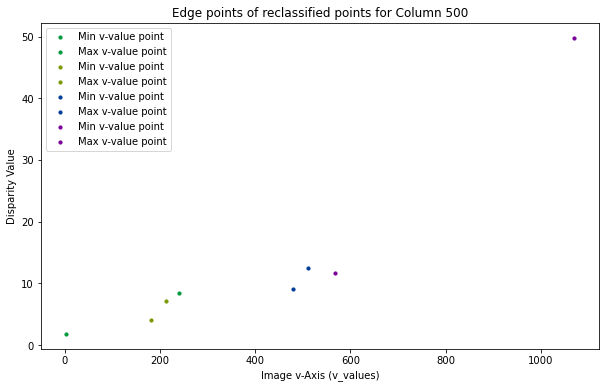

" \n# Reclassify each point and plot them\nreclassified_points = []\nfor idx, v_value in enumerate(indexListHorCol):\n    u_value = column_index  # u_value is the column_index for all points\n    disparity = column_data[v_value]  # Corrected to use index directly\n\n    # Find the line with the minimum perpendicular distance to the point\n    def distance_to_line(line):\n        m, c = line[0]\n        return abs(m * v_value - disparity + c) / np.sqrt(m**2 + 1)\n    \n    closest_line, line_color = min(line_equations, key=lambda line: distance_to_line(line))\n\n    # Store reclassified points with their corresponding color\n    reclassified_points.append((u_value, v_value, disparity, closest_line))\n\n    # Plot each point with the color of the closest regression line\n    plt.scatter(v_value, disparity, color=line_color, s=10)  # Plot with the color of the closest regression line\n\nplt.xlabel('Image v-Axis (v_values)')\nplt.ylabel('Disparity Value')\nplt.title(f'Reclassified Points a

In [ ]:
# Endre/change/velg
# Velg column index here
column_index = 500
size_of_fig=(10, 6)

#Total rows (v) up = 1080
#Total columns (u) right = 1920

# Endre/change/velg
# Velg column data here
column_data = surface_splitting_disparity_image[:, column_index]
y_values = range(len(column_data))

horizontal_column_derivative_list, horizontal_column_object_list, vertical_column_derivative_list, vertical_column_object_list = single_column_list_generator(column_index=column_index)


indexListHorCol = generate_index_list(horizontal_column_object_list)
indexListVertCol = generate_index_list(vertical_column_object_list)

plot_highlighted_scatter = False

if(plot_highlighted_scatter):
    plt.figure()
    #plt.plot(y_values, column_data)

    highlighted_horizontal_y_values = [y_values[i] for i in indexListHorCol]
    highlighted_horizontal_column_data = [column_data[i] for i in indexListHorCol]

    highlighted_vertical_y_values = [y_values[i] for i in indexListVertCol]
    highlighted_vertical_column_data = [column_data[i] for i in indexListVertCol]



    # Plotting highlighted points on top with a different color
    plt.scatter(highlighted_vertical_y_values, highlighted_vertical_column_data, color='red', s=2, zorder=1, label='Highlighted Points')
    plt.scatter(highlighted_horizontal_y_values, highlighted_horizontal_column_data, color='green', s=2, zorder=1, label='Highlighted Points')

    title_for_plot= 'Column index: ' + str(column_index)
    plt.gca()
    plt.ylabel('Disparity Value')
    plt.xlabel('Image v-Axis')
    plt.title(title_for_plot)
    plt.show()

#---------------------------------------------------------------------------------------------------------------------------------------------------------------
# Grouping "adjacent" points (points within a certain number)
#---------------------------------------------------------------------------------------------------------------------------------------------------------------


# The limit for considering pixels to be adjacent
limit = 10

# Function to group indices based on adjacency within a certain limit
def group_indices(indices, limit):
    if not indices:
        return []
    
    # Sort the list of indices first
    sorted_indices = sorted(indices)
    
    # Initialize the list of groups with the first index
    groups = [[sorted_indices[0]]]
    
    # Iterate through the sorted indices starting from the second element
    for index in sorted_indices[1:]:
        # Check if the current index is within the limit of the last index in the last group
        if index - groups[-1][-1] <= limit:
            # If yes, append it to the last group
            groups[-1].append(index)
        else:
            # Otherwise, start a new group
            groups.append([index])
    
    return groups

# Group the indices
grouped_indices = group_indices(indexListHorCol, limit)

# Print the grouped indices
print("Length ",len(grouped_indices))
print("Grouped indices:")
for group in grouped_indices:
    print(group)


# Generate dark colors for the number of groups
colors = generate_dark_colors(len(grouped_indices))

#---------------------------------------------------------------------------------------------------------------------------------------------------------------
# Plotting the grouped points together
#---------------------------------------------------------------------------------------------------------------------------------------------------------------


# Plotting
plt.figure(figsize=size_of_fig)
for i, group in enumerate(grouped_indices):
    # Extract y-values and column_data for each group
    group_y_values = [y_values[idx] for idx in group]
    group_column_data = [column_data[idx] for idx in group]
    

    # Plot each group with a unique color
    plt.scatter(group_y_values, group_column_data, color=colors[i], s=10, label=f'Group {i+1}')

# You can also plot the overall data in the background if needed
#plt.plot(y_values, column_data, color='gray', alpha=0.5)
c = len(grouped_indices)+1/len(grouped_indices)
print("C ", c)
vertical_color = plt.cm.jet(c)
# Labeling and aesthetics and vertical values
#plt.scatter(highlighted_vertical_y_values, highlighted_vertical_column_data, color=vertical_color, s=10, zorder=1, label='Highlighted Points')
plt.xlabel('Image v-Axis')
plt.ylabel('Disparity Value')
plt.title('column_index ' +str(column_index))  # Change accordingly
plt.legend()
plt.show()

#---------------------------------------------------------------------------------------------------------------------------------------------------------------
# Linear regression and plotting
#---------------------------------------------------------------------------------------------------------------------------------------------------------------

min_size = 10

# Plotting the original scatter plot
plt.figure(figsize=size_of_fig)
#---------------------------
# Original scatterplot
#---------------------------
for i, group in enumerate(grouped_indices):
    group_y_values = [y_values[idx] for idx in group]
    group_column_data = [column_data[idx] for idx in group]
    color = plt.cm.jet(i / len(grouped_indices))
    plt.scatter(group_y_values, group_column_data, color=colors[i], s=40, label=f'Group {i+1}')

#---------------------------
# Regression lines    
#---------------------------
# Performing linear regression and plotting lines
for group in grouped_indices:
    if len(group) >= min_size:
        # Extract y-values and column_data for each group
        group_y_values = np.array([y_values[idx] for idx in group])
        group_column_data = np.array([column_data[idx] for idx in group])

        # Linear regression
        A = np.vstack([group_y_values, np.ones(len(group_y_values))]).T
        m, c = np.linalg.lstsq(A, group_column_data, rcond=None)[0]

        # Define the extended line range
        extended_start = min(group_y_values) - 100  # Extend 5 units to the left
        extended_end = max(group_y_values) + 100   # Extend 5 units to the right
        extended_y_values = np.array([extended_start, extended_end])

        # Plotting the regression line
        plt.plot(extended_y_values, m * extended_y_values + c, color='black', linewidth=2)

# Labeling and aesthetics
plt.xlabel('Image v-Axis')
plt.ylabel('Disparity Value')
plt.title('column_index ' +str(column_index))  # Change accordinglyplt.legend()
plt.show()


#------------------------------------------------------
# Reclassifying points based on closest lines 
#------------------------------------------------------


# Initialize list to store line equations and their colors
line_equations = []
plot_linear_regression_lines = False


# Perform linear regression and store the results
if(plot_linear_regression_lines):
    plt.figure(figsize=size_of_fig)
for i, group in enumerate(grouped_indices):
    if len(group) >= min_size:
        group_y_values = np.array([y_values[idx] for idx in group])
        group_column_data = np.array([column_data[idx] for idx in group])

        # Linear regression
        A = np.vstack([group_y_values, np.ones(len(group_y_values))]).T
        m, c = np.linalg.lstsq(A, group_column_data, rcond=None)[0]

        # Store the line equations along with their respective colors
        line_equations.append(((m, c), colors[i]))

        # Define the range for line extension
        extended_start = min(group_y_values) - 100
        extended_end = max(group_y_values) + 100
        extended_y_values = np.array([extended_start, extended_end])

        # Plot each regression line
        if(plot_linear_regression_lines):
            plt.plot(extended_y_values, m * extended_y_values + c, color=colors[i], linewidth=2, label=f'Line: y = {m:.2f}x + {c:.2f}')

if(plot_linear_regression_lines):
    plt.xlabel('Image v-Axis (v_values)')
    plt.ylabel('Disparity Value')
    plt.title(f'Grouped Points and Regression Lines for Column {column_index}')
    plt.legend()
    plt.show()


# Initialize storage for the edge values for each line
edge_points = {}  # Will map line (slope, intercept) to its min and max v-value points

# Initialize reclassified points list
reclassified_points = []

plot_only_edge_points = True
plot_reclassified_points = True
if(plot_reclassified_points):
    plt.figure(figsize=size_of_fig)
for idx, v_value in enumerate(indexListHorCol):
    u_value = column_index  # u_value is the column_index for all points
    disparity = column_data[v_value]  # Corrected to use index directly

    # Find the line with the minimum perpendicular distance to the point
    def distance_to_line(line):
        m, c = line[0]
        return abs(m * v_value - disparity + c) / np.sqrt(m**2 + 1)
    
    closest_line, line_color = min(line_equations, key=lambda line: distance_to_line(line))

    # Update edge points dictionary
    if closest_line not in edge_points:
        edge_points[closest_line] = {
            'min_v': (float('inf'), None),  # Store (v_value, point, color)
            'max_v': (float('-inf'), None)  # Store (v_value, point, color)
        }

    # Check for min or max v-values
    if v_value < edge_points[closest_line]['min_v'][0]:
        edge_points[closest_line]['min_v'] = (v_value, (u_value, v_value, disparity), line_color)
    if v_value > edge_points[closest_line]['max_v'][0]:
        edge_points[closest_line]['max_v'] = (v_value, (u_value, v_value, disparity), line_color)

    # Store reclassified points with their corresponding color for other uses
    reclassified_points.append((u_value, v_value, disparity, closest_line, line_color))
    if(plot_reclassified_points):
        plt.scatter(v_value, disparity, color=line_color, s=10)

        
if(plot_reclassified_points):
    plt.xlabel('Image v-Axis (v_values)')
    plt.ylabel('Disparity Value')
    plt.title(f'Reclassified horizontal Points for Column {column_index}')
    plt.legend()
    plt.show()

if(plot_only_edge_points):
    #    Plot edge points
    plt.figure(figsize=size_of_fig)
    for line_info in edge_points.values():
        min_v_point = line_info['min_v']
        max_v_point = line_info['max_v']
        if min_v_point[1] is not None:  # Check if an actual point was stored
            plt.scatter(min_v_point[1][1], min_v_point[1][2], color=min_v_point[2], s=10, label='Min v-value point')
        if max_v_point[1] is not None:
            plt.scatter(max_v_point[1][1], max_v_point[1][2], color=max_v_point[2], s=10, label='Max v-value point')

    plt.xlabel('Image v-Axis (v_values)')
    plt.ylabel('Disparity Value')
    plt.title(f'Edge points of reclassified points for Column {column_index}')
    plt.legend()
    plt.show()

""" if(plot_reclassified_points): 
    plt.figure(figsize=size_of_fig)
    for point in reclassified_points:
        plt.scatter(point[1], point[2], color=point[line_color], s=10)  # Plot with the color of the closest regression line

    
 """
""" 
# Reclassify each point and plot them
reclassified_points = []
for idx, v_value in enumerate(indexListHorCol):
    u_value = column_index  # u_value is the column_index for all points
    disparity = column_data[v_value]  # Corrected to use index directly

    # Find the line with the minimum perpendicular distance to the point
    def distance_to_line(line):
        m, c = line[0]
        return abs(m * v_value - disparity + c) / np.sqrt(m**2 + 1)
    
    closest_line, line_color = min(line_equations, key=lambda line: distance_to_line(line))

    # Store reclassified points with their corresponding color
    reclassified_points.append((u_value, v_value, disparity, closest_line))

    # Plot each point with the color of the closest regression line
    plt.scatter(v_value, disparity, color=line_color, s=10)  # Plot with the color of the closest regression line

plt.xlabel('Image v-Axis (v_values)')
plt.ylabel('Disparity Value')
plt.title(f'Reclassified Points and Regression Lines for Column {column_index}')
plt.legend()
plt.show()
 """

# Clustering attempts for intersection values, column wise and full picture. 
### Below

In [ ]:
plot_all_disp_vals = False
if(plot_all_disp_vals):
    input_bins=400
    title = 'Histogram of vertical disparities of upright labeled pixels'
    histRange = (-0.3,0.5)

    #to_be_plotted = verticalDerivativeList
    #to_be_plotted = df_derivative.flatten()
    to_be_plotted =horizontal_Disp_List
    to_be_plotted2 = vertical_Disp_List
    histRange = (-10,60)
    # Plot the histogram
    plt.figure()
    plt.hist(to_be_plotted, bins=input_bins, range=histRange, color='green', edgecolor='green')
    plt.hist(to_be_plotted2, bins=input_bins, range=histRange, color='red', edgecolor='red')
    plt.title(title)
    plt.xlabel('Disparity Value')
    plt.ylabel('Frequency')
    # Show the plot
    plt.show()


In [ ]:
print("Column index: ", column_index)
v_1 = 502
print("v_1 ", v_1)
v_2 = 510
print("v_2 ", v_2)


def compute_intersect(index1, index2, column_data=column_data):
    dVal1 = column_data[index1]
    dVal2 = column_data[index2]

    deltaVIndex = index2 -index1
    deltaDval = dVal2 - dVal1

    comp_intersect = index1 - (deltaVIndex/deltaDval * dVal1)

    return comp_intersect


d_1 = column_data[v_1]
print("d_1 ",d_1 )
d_2 = column_data[v_2]
print("d_2 ",d_2 )

deltaV = v_2 - v_1

deltaD = d_2 - d_1

slope = deltaD/deltaV


#v_intersect = v_1 - (deltaV/deltaD * d_1)

v_intersect  = compute_intersect(v_1, v_2)


print("DeltaV ", deltaV)
print("DeltaD ", deltaD)

print("Intersect ", v_intersect)


x_line = [v_1, v_2, v_intersect] 
y_line = [d_1, d_2, 0]  

plt.figure()
plt.plot(y_values, column_data)
plt.scatter([v_intersect, v_1, v_2], [0, d_1, d_2], color='red', s=10, zorder=5)  # s is the size of the point, zorder specifies drawing order
plt.plot(x_line, y_line, color='green', linewidth=2, linestyle='-', zorder=4)
plt.gca()
plt.ylabel('Disparity Value')
plt.xlabel('Image v-Axis')
plt.title('Disparity Values Along a Column')
plt.show()

In [ ]:
horizontal_points_and_intersects = []

for i in range(len(indexListHorCol)-1):
    indexVal1 = indexListHorCol[i]
    indexVal2 = indexListHorCol[i+1]

    intersect_Value = compute_intersect(indexVal1, indexVal2)
    disparityVal =  column_data[indexVal1]
    
    horizontal_points_and_intersects.append((indexVal1, disparityVal, intersect_Value))

v_vals_inter, disparity_vals_inter, horizontal_intersect_vals = zip(*horizontal_points_and_intersects)

print(horizontal_intersect_vals)

plt.figure()
plt.scatter(horizontal_intersect_vals, v_vals_inter)
plt.xlim(-100, 1000)
plt.gca()
plt.ylabel('Disparity Value')
plt.xlabel('Image v-Axis')
plt.title('Disparity Values Along a Column')
plt.show()

input_bins=300
title = 'Histogram of intersections of horizontal axis'
histRange = (-0,1000)
#to_be_plotted = verticalDerivativeList
#to_be_plotted = df_derivative.flatten()

# Plot the histogram
plt.figure()
plt.hist(horizontal_intersect_vals, bins=input_bins, range=histRange, color='green', edgecolor='green')
plt.title(title)
plt.xlabel('Intersectionvalues Value')
plt.ylabel('V values')
# Show the plot
plt.show()

detected_modes = plot_histogram_with_peaks(horizontal_intersect_vals, bins=100, min_prominence=0.02, min_distance=1, auto_range=(histRange))

In [ ]:
filter_horizontal_intersect_valsed_data = [value for value in horizontal_intersect_vals if not math.isnan(value)]

print(filter_horizontal_intersect_valsed_data)

clipped_derivatives = np.clip(filter_horizontal_intersect_valsed_data, a_min=histRange[0], a_max=histRange[1])

# Reshape data for KMeans
clustering_model = clipped_derivatives.reshape(-1, 1)

num_clusters=2
# Perform K-means clustering
#kmeans = KMeans(n_clusters=clusters, init=initial_centers,n_init=2)
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init=10)
kmeans.fit(clustering_model)

# Get the labels and cluster centers
labels_inter = kmeans.labels_
centers_inter = kmeans.cluster_centers_
    
# Separate the data into two clusters

if(num_clusters>= 1):
    cluster1_inter = clustering_model[labels_inter == 0]
if(num_clusters>= 2):
    cluster2_inter = clustering_model[labels_inter == 1]
if(num_clusters >= 3):
    cluster3_inter = clustering_model[labels_inter == 2]
if(num_clusters >= 4):
    cluster4_inter = clustering_model[labels_inter == 3]
if(num_clusters >= 5):
    cluster5_inter = clustering_model[labels_inter == 4]



# Plot histogram and Gaussian curves
plt.figure()
if(num_clusters>= 1):
    plt.hist(cluster1_inter, bins=200, range=histRange, density=True, alpha=0.6, color='blue', edgecolor='blue')
if(num_clusters>= 2):
    plt.hist(cluster2_inter, bins=200, range=histRange, density=True, alpha=0.6, color='red', edgecolor='red')
if(num_clusters>= 3):
    plt.hist(cluster3_inter, bins=200, range=histRange, density=True, alpha=0.6, color='green', edgecolor='green')
if(num_clusters>= 4):
    plt.hist(cluster4_inter, bins=200, range=histRange, density=True, alpha=0.6, color='yellow', edgecolor='yellow')
if(num_clusters>= 5):
    plt.hist(cluster5_inter, bins=200, range=histRange, density=True, alpha=0.6, color='purple', edgecolor='purple')
#plt.plot(x_values, gaussian_curve1, label='Gaussian 1')
#plt.plot(x_values, gaussian_curve2, label='Gaussian 2')
plt.xlabel('Derivative Values')
plt.ylabel('Frequency')
plt.title('Histogram with Fitted Gaussian Curves')
plt.legend()
plt.show()

In [ ]:
# 0: Disparity Value    1: Derivative Value     2: V index    3: U index   4: Label]")

#print("[Disparity Value, Derivative Value, V index, U index, Label]")
#print(horizontal_Obj_List[200])

all_horizontal_intersections_listy = []

for index in range(surface_splitting_disparity_image.shape[1]):


    current_column_data = surface_splitting_disparity_image[:, index]
    current_y_values = range(len(current_column_data))
    
    local_list_col_objects = single_column_list_generator(index, True)

    local_index_list_horizontal = generate_index_list(local_list_col_objects)

    all_horizontal_intersections_listy.append(local_index_list_horizontal)

print(all_horizontal_intersections_listy[column_index])
print(indexListHorCol)
 

In [ ]:
all_horizontal_intersections = []

list_count = 0
for list in all_horizontal_intersections_listy:

    for i in range(len(list)-1):

        indexVal1 = list[i]
        indexVal2 = list[i+1]

        intersect_Value = compute_intersect(indexVal1, indexVal2, column_data=surface_splitting_disparity_image[:,list_count])
        
        all_horizontal_intersections.append(intersect_Value)

    list_count += 1

print(all_horizontal_intersections[1])



In [ ]:

input_bins=2000
title = 'Histogram of intersections of horizontal axis'
histRange = (-250,1000)
#to_be_plotted = verticalDerivativeList
#to_be_plotted = df_derivative.flatten()

# Plot the histogram
plt.figure()
plt.hist(all_horizontal_intersections, bins=input_bins, range=histRange, color='green', edgecolor='green')
plt.title(title)
plt.xlabel('Intersectionvalues Value')
plt.ylabel('V values')
# Show the plot
plt.show()

detected_modes = plot_histogram_with_peaks(all_horizontal_intersections, bins=100, min_prominence=0.02, min_distance=1, auto_range=(histRange))

In [ ]:
run_all_intersections = False
if(run_all_intersections):
    for i in range(len(v_vals_inter)):
        x_line = [v_vals_inter[i], horizontal_intersect_vals[i]] 
        y_line = [disparity_vals_inter[i], 0]  


        if((x_line[0]>x_line[1])):
            plt.figure()
            plt.plot(y_values, column_data)
            #plt.scatter([v_intersect, v_1, v_2], [0, d_1, d_2], color='red', s=10, zorder=5)  # s is the size of the point, zorder specifies drawing order
            plt.plot(x_line, y_line, color='red', linewidth=2, linestyle='-', zorder=4)
            plt.gca()
            plt.ylabel('Disparity Value')
            plt.xlabel('Image v-Axis')
            plt.title('Disparity Values Along a Column')
            #plt.pause(1.5)
            plt.show()
        